# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

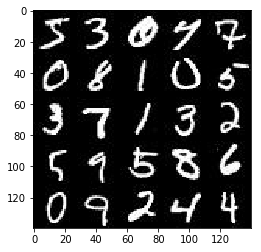

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

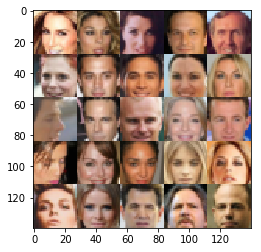

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/mtx/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(input, alpha = 0.15):
    activation = tf.maximum(alpha * input, input) 
    return activation

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = leaky_relu(x1)
        #relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        #relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #alpha = 0.2
    reuse = False if is_train else True
    
    with tf.variable_scope('generator',reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        #x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x12 = tf.layers.conv2d_transpose(x1,256,kernel_size=4,strides=1,padding='valid')#,use_bias=False)
        x12 = tf.layers.batch_normalization(x12, training=is_train)
        x12 = leaky_relu(x12)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x12,128,kernel_size=5,strides=1,padding='same')#,use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        #x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)#, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real)#, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)#, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import matplotlib.pyplot as plt
def loss_plots(losses):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10 
    show_every = 100
    #figsize=(5,5)
    
    if data_image_mode == "RGB":
        out_dim = 3
    elif data_image_mode == "L":
        out_dim = 1
    
    #tf.reset_default_graph()
    #print('data_shape',data_shape)
    #print(data_shape[1],data_shape[2],data_shape[3])
    
    input_real, input_z,l_rate = model_inputs(data_shape[1],data_shape[2],out_dim, z_dim)
    #print(input_real,input_z)
    d_loss, g_loss = model_loss(input_real, input_z, out_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    #n_images = 72
    sample_z = np.random.uniform(-1, 1, size=(show_n_images, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                #print(steps,type(steps),print_every,type(print_every))
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..".format(epoch_i+1, epoch_count),
                          "Steps {}..".format(steps),
                          "Discriminator Loss: {:.4f}..".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                
                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, show_n_images, input_z, out_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    import pickle as pkl
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    loss_plots(losses)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2.. Steps 10.. Discriminator Loss: 3.8607.. Generator Loss: 0.0325
Epoch 1/2.. Steps 20.. Discriminator Loss: 0.5745.. Generator Loss: 11.1620
Epoch 1/2.. Steps 30.. Discriminator Loss: 0.9874.. Generator Loss: 4.2572
Epoch 1/2.. Steps 40.. Discriminator Loss: 0.4490.. Generator Loss: 4.4552
Epoch 1/2.. Steps 50.. Discriminator Loss: 1.1882.. Generator Loss: 5.6330
Epoch 1/2.. Steps 60.. Discriminator Loss: 0.8964.. Generator Loss: 1.1762
Epoch 1/2.. Steps 70.. Discriminator Loss: 0.7590.. Generator Loss: 3.7578
Epoch 1/2.. Steps 80.. Discriminator Loss: 0.9911.. Generator Loss: 0.8942
Epoch 1/2.. Steps 90.. Discriminator Loss: 0.4793.. Generator Loss: 2.9299
Epoch 1/2.. Steps 100.. Discriminator Loss: 0.5159.. Generator Loss: 3.1329


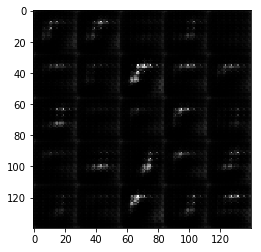

Epoch 1/2.. Steps 110.. Discriminator Loss: 0.6063.. Generator Loss: 1.9161
Epoch 1/2.. Steps 120.. Discriminator Loss: 1.7087.. Generator Loss: 0.9728
Epoch 1/2.. Steps 130.. Discriminator Loss: 1.0117.. Generator Loss: 0.9500
Epoch 1/2.. Steps 140.. Discriminator Loss: 1.0823.. Generator Loss: 0.8417
Epoch 1/2.. Steps 150.. Discriminator Loss: 0.8858.. Generator Loss: 1.0275
Epoch 1/2.. Steps 160.. Discriminator Loss: 0.6429.. Generator Loss: 2.1173
Epoch 1/2.. Steps 170.. Discriminator Loss: 1.1014.. Generator Loss: 0.9809
Epoch 1/2.. Steps 180.. Discriminator Loss: 0.6984.. Generator Loss: 1.5932
Epoch 1/2.. Steps 190.. Discriminator Loss: 2.3480.. Generator Loss: 0.2761
Epoch 1/2.. Steps 200.. Discriminator Loss: 1.0669.. Generator Loss: 1.5225


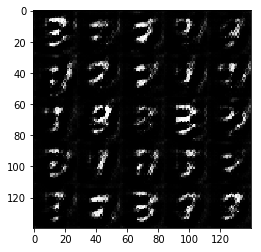

Epoch 1/2.. Steps 210.. Discriminator Loss: 0.9389.. Generator Loss: 3.0042
Epoch 1/2.. Steps 220.. Discriminator Loss: 1.0603.. Generator Loss: 0.7776
Epoch 1/2.. Steps 230.. Discriminator Loss: 0.7714.. Generator Loss: 1.4444
Epoch 1/2.. Steps 240.. Discriminator Loss: 1.3372.. Generator Loss: 0.6538
Epoch 1/2.. Steps 250.. Discriminator Loss: 0.7615.. Generator Loss: 1.6708
Epoch 1/2.. Steps 260.. Discriminator Loss: 0.7176.. Generator Loss: 1.8907
Epoch 1/2.. Steps 270.. Discriminator Loss: 0.9137.. Generator Loss: 1.9132
Epoch 1/2.. Steps 280.. Discriminator Loss: 1.0195.. Generator Loss: 1.9285
Epoch 1/2.. Steps 290.. Discriminator Loss: 2.6817.. Generator Loss: 4.1620
Epoch 1/2.. Steps 300.. Discriminator Loss: 1.0529.. Generator Loss: 1.2124


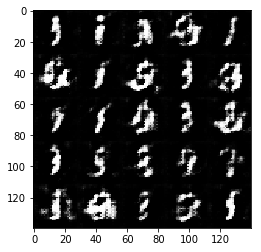

Epoch 1/2.. Steps 310.. Discriminator Loss: 1.0602.. Generator Loss: 0.9281
Epoch 1/2.. Steps 320.. Discriminator Loss: 1.0723.. Generator Loss: 1.1004
Epoch 1/2.. Steps 330.. Discriminator Loss: 1.1862.. Generator Loss: 1.1919
Epoch 1/2.. Steps 340.. Discriminator Loss: 0.9660.. Generator Loss: 1.2665
Epoch 1/2.. Steps 350.. Discriminator Loss: 1.1653.. Generator Loss: 1.3728
Epoch 1/2.. Steps 360.. Discriminator Loss: 1.3368.. Generator Loss: 0.6093
Epoch 1/2.. Steps 370.. Discriminator Loss: 1.4793.. Generator Loss: 0.5075
Epoch 1/2.. Steps 380.. Discriminator Loss: 1.1077.. Generator Loss: 0.8565
Epoch 1/2.. Steps 390.. Discriminator Loss: 0.9848.. Generator Loss: 0.9139
Epoch 1/2.. Steps 400.. Discriminator Loss: 1.2097.. Generator Loss: 0.8202


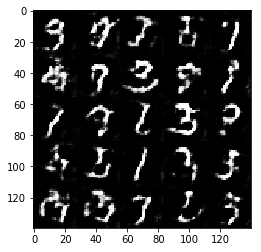

Epoch 1/2.. Steps 410.. Discriminator Loss: 2.0917.. Generator Loss: 0.2426
Epoch 1/2.. Steps 420.. Discriminator Loss: 0.8979.. Generator Loss: 1.5335
Epoch 1/2.. Steps 430.. Discriminator Loss: 1.1787.. Generator Loss: 1.0838
Epoch 1/2.. Steps 440.. Discriminator Loss: 1.2189.. Generator Loss: 1.1152
Epoch 1/2.. Steps 450.. Discriminator Loss: 0.9227.. Generator Loss: 1.4083
Epoch 1/2.. Steps 460.. Discriminator Loss: 1.3570.. Generator Loss: 1.7448
Epoch 1/2.. Steps 470.. Discriminator Loss: 1.0230.. Generator Loss: 1.2297
Epoch 1/2.. Steps 480.. Discriminator Loss: 1.0124.. Generator Loss: 1.1699
Epoch 1/2.. Steps 490.. Discriminator Loss: 0.9411.. Generator Loss: 1.3124
Epoch 1/2.. Steps 500.. Discriminator Loss: 1.4977.. Generator Loss: 0.4854


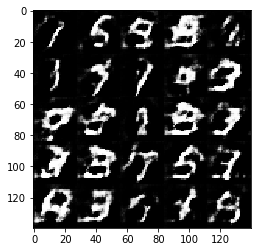

Epoch 1/2.. Steps 510.. Discriminator Loss: 1.1666.. Generator Loss: 1.1717
Epoch 1/2.. Steps 520.. Discriminator Loss: 1.1590.. Generator Loss: 0.7593
Epoch 1/2.. Steps 530.. Discriminator Loss: 1.0940.. Generator Loss: 1.1173
Epoch 1/2.. Steps 540.. Discriminator Loss: 1.0957.. Generator Loss: 1.3239
Epoch 1/2.. Steps 550.. Discriminator Loss: 1.0921.. Generator Loss: 1.6793
Epoch 1/2.. Steps 560.. Discriminator Loss: 1.4375.. Generator Loss: 2.1581
Epoch 1/2.. Steps 570.. Discriminator Loss: 1.0778.. Generator Loss: 1.3166
Epoch 1/2.. Steps 580.. Discriminator Loss: 1.4097.. Generator Loss: 0.5848
Epoch 1/2.. Steps 590.. Discriminator Loss: 1.0174.. Generator Loss: 1.7408
Epoch 1/2.. Steps 600.. Discriminator Loss: 1.2783.. Generator Loss: 0.9231


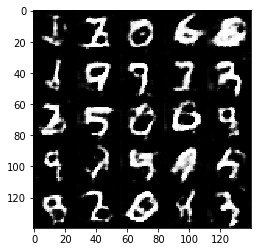

Epoch 1/2.. Steps 610.. Discriminator Loss: 1.0044.. Generator Loss: 1.0216
Epoch 1/2.. Steps 620.. Discriminator Loss: 1.1564.. Generator Loss: 1.4193
Epoch 1/2.. Steps 630.. Discriminator Loss: 1.1569.. Generator Loss: 1.6060
Epoch 1/2.. Steps 640.. Discriminator Loss: 1.1688.. Generator Loss: 1.1146
Epoch 1/2.. Steps 650.. Discriminator Loss: 1.1647.. Generator Loss: 1.5179
Epoch 1/2.. Steps 660.. Discriminator Loss: 1.0606.. Generator Loss: 1.2970
Epoch 1/2.. Steps 670.. Discriminator Loss: 1.3875.. Generator Loss: 1.6299
Epoch 1/2.. Steps 680.. Discriminator Loss: 1.0991.. Generator Loss: 0.9810
Epoch 1/2.. Steps 690.. Discriminator Loss: 1.1265.. Generator Loss: 0.9029
Epoch 1/2.. Steps 700.. Discriminator Loss: 0.9933.. Generator Loss: 1.0268


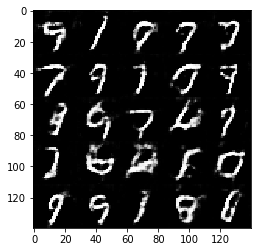

Epoch 1/2.. Steps 710.. Discriminator Loss: 1.3797.. Generator Loss: 0.6974
Epoch 1/2.. Steps 720.. Discriminator Loss: 0.9854.. Generator Loss: 1.1499
Epoch 1/2.. Steps 730.. Discriminator Loss: 1.1809.. Generator Loss: 0.7138
Epoch 1/2.. Steps 740.. Discriminator Loss: 1.0635.. Generator Loss: 0.9494
Epoch 1/2.. Steps 750.. Discriminator Loss: 0.9340.. Generator Loss: 1.8600
Epoch 1/2.. Steps 760.. Discriminator Loss: 1.3034.. Generator Loss: 2.2559
Epoch 1/2.. Steps 770.. Discriminator Loss: 1.0169.. Generator Loss: 1.1571
Epoch 1/2.. Steps 780.. Discriminator Loss: 1.3800.. Generator Loss: 0.6133
Epoch 1/2.. Steps 790.. Discriminator Loss: 0.9462.. Generator Loss: 1.6758
Epoch 1/2.. Steps 800.. Discriminator Loss: 1.1808.. Generator Loss: 1.0264


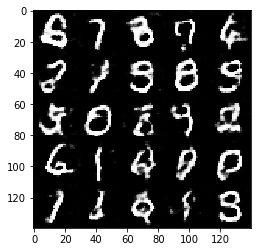

Epoch 1/2.. Steps 810.. Discriminator Loss: 0.8562.. Generator Loss: 1.0890
Epoch 1/2.. Steps 820.. Discriminator Loss: 1.0141.. Generator Loss: 1.1252
Epoch 1/2.. Steps 830.. Discriminator Loss: 1.1724.. Generator Loss: 0.8594
Epoch 1/2.. Steps 840.. Discriminator Loss: 1.1285.. Generator Loss: 1.1091
Epoch 1/2.. Steps 850.. Discriminator Loss: 0.9579.. Generator Loss: 1.3675
Epoch 1/2.. Steps 860.. Discriminator Loss: 1.1701.. Generator Loss: 1.4615
Epoch 1/2.. Steps 870.. Discriminator Loss: 1.0511.. Generator Loss: 0.9558
Epoch 1/2.. Steps 880.. Discriminator Loss: 1.6352.. Generator Loss: 0.3668
Epoch 1/2.. Steps 890.. Discriminator Loss: 1.2615.. Generator Loss: 0.6456
Epoch 1/2.. Steps 900.. Discriminator Loss: 0.9766.. Generator Loss: 1.5812


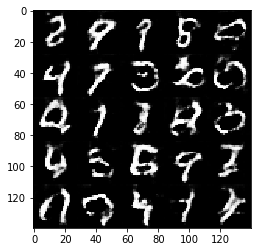

Epoch 1/2.. Steps 910.. Discriminator Loss: 0.9553.. Generator Loss: 1.4532
Epoch 1/2.. Steps 920.. Discriminator Loss: 1.1396.. Generator Loss: 0.9293
Epoch 1/2.. Steps 930.. Discriminator Loss: 1.1149.. Generator Loss: 1.7095
Epoch 1/2.. Steps 940.. Discriminator Loss: 1.2585.. Generator Loss: 0.7772
Epoch 1/2.. Steps 950.. Discriminator Loss: 1.0224.. Generator Loss: 0.9736
Epoch 1/2.. Steps 960.. Discriminator Loss: 0.9557.. Generator Loss: 1.5032
Epoch 1/2.. Steps 970.. Discriminator Loss: 1.0772.. Generator Loss: 0.8567
Epoch 1/2.. Steps 980.. Discriminator Loss: 1.0171.. Generator Loss: 1.5968
Epoch 1/2.. Steps 990.. Discriminator Loss: 1.2354.. Generator Loss: 0.6735
Epoch 1/2.. Steps 1000.. Discriminator Loss: 1.2144.. Generator Loss: 0.6018


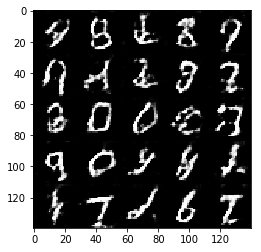

Epoch 1/2.. Steps 1010.. Discriminator Loss: 1.6806.. Generator Loss: 0.3746
Epoch 1/2.. Steps 1020.. Discriminator Loss: 1.0189.. Generator Loss: 1.8080
Epoch 1/2.. Steps 1030.. Discriminator Loss: 1.1120.. Generator Loss: 0.9896
Epoch 1/2.. Steps 1040.. Discriminator Loss: 0.9883.. Generator Loss: 1.5102
Epoch 1/2.. Steps 1050.. Discriminator Loss: 0.8995.. Generator Loss: 1.2122
Epoch 1/2.. Steps 1060.. Discriminator Loss: 1.1314.. Generator Loss: 1.4502
Epoch 1/2.. Steps 1070.. Discriminator Loss: 1.0826.. Generator Loss: 0.8310
Epoch 1/2.. Steps 1080.. Discriminator Loss: 1.2427.. Generator Loss: 0.6485
Epoch 1/2.. Steps 1090.. Discriminator Loss: 0.7930.. Generator Loss: 1.3037
Epoch 1/2.. Steps 1100.. Discriminator Loss: 0.9939.. Generator Loss: 1.0744


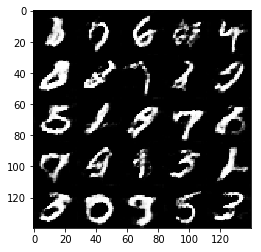

Epoch 1/2.. Steps 1110.. Discriminator Loss: 1.1298.. Generator Loss: 0.8086
Epoch 1/2.. Steps 1120.. Discriminator Loss: 1.2077.. Generator Loss: 0.8221
Epoch 1/2.. Steps 1130.. Discriminator Loss: 1.0597.. Generator Loss: 0.9826
Epoch 1/2.. Steps 1140.. Discriminator Loss: 1.4236.. Generator Loss: 0.5314
Epoch 1/2.. Steps 1150.. Discriminator Loss: 0.9933.. Generator Loss: 1.2602
Epoch 1/2.. Steps 1160.. Discriminator Loss: 0.9798.. Generator Loss: 1.1874
Epoch 1/2.. Steps 1170.. Discriminator Loss: 1.2878.. Generator Loss: 0.5330
Epoch 1/2.. Steps 1180.. Discriminator Loss: 0.9376.. Generator Loss: 1.5593
Epoch 1/2.. Steps 1190.. Discriminator Loss: 0.9930.. Generator Loss: 0.9410
Epoch 1/2.. Steps 1200.. Discriminator Loss: 0.9880.. Generator Loss: 0.9844


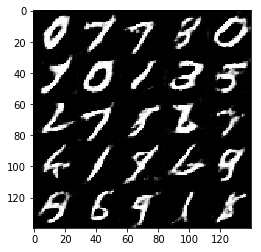

Epoch 1/2.. Steps 1210.. Discriminator Loss: 1.4406.. Generator Loss: 0.4753
Epoch 1/2.. Steps 1220.. Discriminator Loss: 1.1932.. Generator Loss: 1.0180
Epoch 1/2.. Steps 1230.. Discriminator Loss: 1.0924.. Generator Loss: 1.0480
Epoch 1/2.. Steps 1240.. Discriminator Loss: 1.1404.. Generator Loss: 1.0406
Epoch 1/2.. Steps 1250.. Discriminator Loss: 1.1480.. Generator Loss: 0.7814
Epoch 1/2.. Steps 1260.. Discriminator Loss: 1.0986.. Generator Loss: 1.5698
Epoch 1/2.. Steps 1270.. Discriminator Loss: 1.0224.. Generator Loss: 0.8507
Epoch 1/2.. Steps 1280.. Discriminator Loss: 1.0006.. Generator Loss: 1.5409
Epoch 1/2.. Steps 1290.. Discriminator Loss: 1.2098.. Generator Loss: 0.9146
Epoch 1/2.. Steps 1300.. Discriminator Loss: 1.2969.. Generator Loss: 1.1217


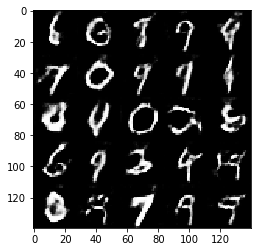

Epoch 1/2.. Steps 1310.. Discriminator Loss: 1.1146.. Generator Loss: 1.1018
Epoch 1/2.. Steps 1320.. Discriminator Loss: 1.4726.. Generator Loss: 0.4731
Epoch 1/2.. Steps 1330.. Discriminator Loss: 1.2592.. Generator Loss: 1.2978
Epoch 1/2.. Steps 1340.. Discriminator Loss: 1.2302.. Generator Loss: 0.6704
Epoch 1/2.. Steps 1350.. Discriminator Loss: 1.0237.. Generator Loss: 0.9561
Epoch 1/2.. Steps 1360.. Discriminator Loss: 1.2589.. Generator Loss: 0.7611
Epoch 1/2.. Steps 1370.. Discriminator Loss: 1.3714.. Generator Loss: 1.6590
Epoch 1/2.. Steps 1380.. Discriminator Loss: 1.3294.. Generator Loss: 0.5542
Epoch 1/2.. Steps 1390.. Discriminator Loss: 0.8711.. Generator Loss: 1.3799
Epoch 1/2.. Steps 1400.. Discriminator Loss: 1.4705.. Generator Loss: 0.4921


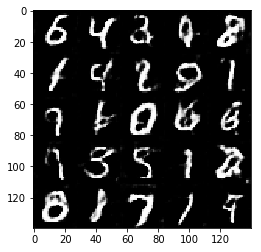

Epoch 1/2.. Steps 1410.. Discriminator Loss: 1.0213.. Generator Loss: 0.9638
Epoch 1/2.. Steps 1420.. Discriminator Loss: 1.0735.. Generator Loss: 1.3169
Epoch 1/2.. Steps 1430.. Discriminator Loss: 1.1057.. Generator Loss: 1.7066
Epoch 1/2.. Steps 1440.. Discriminator Loss: 1.2088.. Generator Loss: 0.8166
Epoch 1/2.. Steps 1450.. Discriminator Loss: 1.2166.. Generator Loss: 0.6468
Epoch 1/2.. Steps 1460.. Discriminator Loss: 1.0192.. Generator Loss: 1.7749
Epoch 1/2.. Steps 1470.. Discriminator Loss: 1.4574.. Generator Loss: 0.4767
Epoch 1/2.. Steps 1480.. Discriminator Loss: 1.5973.. Generator Loss: 0.4069
Epoch 1/2.. Steps 1490.. Discriminator Loss: 1.4300.. Generator Loss: 0.6534
Epoch 1/2.. Steps 1500.. Discriminator Loss: 1.0356.. Generator Loss: 1.0354


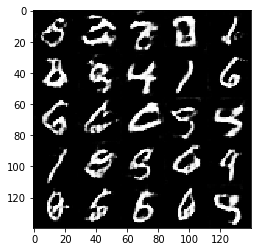

Epoch 1/2.. Steps 1510.. Discriminator Loss: 1.1015.. Generator Loss: 0.8182
Epoch 1/2.. Steps 1520.. Discriminator Loss: 0.9083.. Generator Loss: 1.7714
Epoch 1/2.. Steps 1530.. Discriminator Loss: 1.4758.. Generator Loss: 0.4829
Epoch 1/2.. Steps 1540.. Discriminator Loss: 1.0593.. Generator Loss: 0.8184
Epoch 1/2.. Steps 1550.. Discriminator Loss: 1.1225.. Generator Loss: 0.7988
Epoch 1/2.. Steps 1560.. Discriminator Loss: 1.0011.. Generator Loss: 1.1653
Epoch 1/2.. Steps 1570.. Discriminator Loss: 1.2410.. Generator Loss: 0.6833
Epoch 1/2.. Steps 1580.. Discriminator Loss: 1.3415.. Generator Loss: 0.6075
Epoch 1/2.. Steps 1590.. Discriminator Loss: 1.1654.. Generator Loss: 0.6886
Epoch 1/2.. Steps 1600.. Discriminator Loss: 1.1049.. Generator Loss: 0.9628


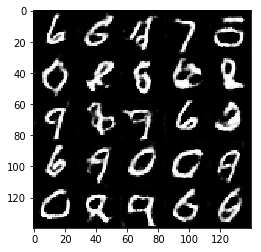

Epoch 1/2.. Steps 1610.. Discriminator Loss: 1.2662.. Generator Loss: 0.7316
Epoch 1/2.. Steps 1620.. Discriminator Loss: 0.9333.. Generator Loss: 1.2680
Epoch 1/2.. Steps 1630.. Discriminator Loss: 0.9436.. Generator Loss: 1.0002
Epoch 1/2.. Steps 1640.. Discriminator Loss: 1.1903.. Generator Loss: 0.7368
Epoch 1/2.. Steps 1650.. Discriminator Loss: 0.9517.. Generator Loss: 1.0500
Epoch 1/2.. Steps 1660.. Discriminator Loss: 0.9807.. Generator Loss: 0.9910
Epoch 1/2.. Steps 1670.. Discriminator Loss: 1.2678.. Generator Loss: 0.5850
Epoch 1/2.. Steps 1680.. Discriminator Loss: 0.8206.. Generator Loss: 1.4585
Epoch 1/2.. Steps 1690.. Discriminator Loss: 1.1339.. Generator Loss: 1.8193
Epoch 1/2.. Steps 1700.. Discriminator Loss: 1.0085.. Generator Loss: 1.8498


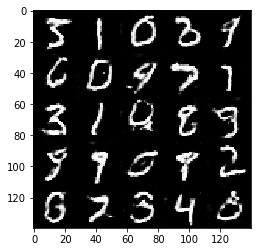

Epoch 1/2.. Steps 1710.. Discriminator Loss: 0.8235.. Generator Loss: 1.2673
Epoch 1/2.. Steps 1720.. Discriminator Loss: 0.9849.. Generator Loss: 1.0995
Epoch 1/2.. Steps 1730.. Discriminator Loss: 1.1856.. Generator Loss: 0.8283
Epoch 1/2.. Steps 1740.. Discriminator Loss: 1.1532.. Generator Loss: 0.8400
Epoch 1/2.. Steps 1750.. Discriminator Loss: 1.3516.. Generator Loss: 2.6296
Epoch 1/2.. Steps 1760.. Discriminator Loss: 1.0754.. Generator Loss: 0.8738
Epoch 1/2.. Steps 1770.. Discriminator Loss: 1.2658.. Generator Loss: 0.6948
Epoch 1/2.. Steps 1780.. Discriminator Loss: 0.8448.. Generator Loss: 1.3692
Epoch 1/2.. Steps 1790.. Discriminator Loss: 0.8600.. Generator Loss: 1.5381
Epoch 1/2.. Steps 1800.. Discriminator Loss: 0.8830.. Generator Loss: 1.8741


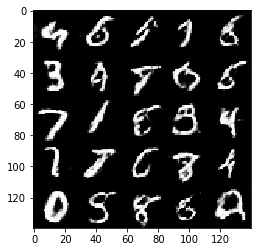

Epoch 1/2.. Steps 1810.. Discriminator Loss: 1.0639.. Generator Loss: 1.4650
Epoch 1/2.. Steps 1820.. Discriminator Loss: 1.1581.. Generator Loss: 0.8787
Epoch 1/2.. Steps 1830.. Discriminator Loss: 0.8177.. Generator Loss: 1.4705
Epoch 1/2.. Steps 1840.. Discriminator Loss: 1.1025.. Generator Loss: 2.1874
Epoch 1/2.. Steps 1850.. Discriminator Loss: 1.2229.. Generator Loss: 0.6304
Epoch 1/2.. Steps 1860.. Discriminator Loss: 1.1615.. Generator Loss: 0.7246
Epoch 1/2.. Steps 1870.. Discriminator Loss: 1.0323.. Generator Loss: 0.8703
Epoch 2/2.. Steps 1880.. Discriminator Loss: 0.7872.. Generator Loss: 1.8178
Epoch 2/2.. Steps 1890.. Discriminator Loss: 0.7811.. Generator Loss: 1.6982
Epoch 2/2.. Steps 1900.. Discriminator Loss: 0.8472.. Generator Loss: 1.3868


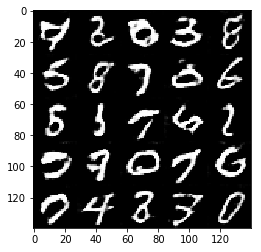

Epoch 2/2.. Steps 1910.. Discriminator Loss: 1.1386.. Generator Loss: 0.7664
Epoch 2/2.. Steps 1920.. Discriminator Loss: 1.0514.. Generator Loss: 1.4647
Epoch 2/2.. Steps 1930.. Discriminator Loss: 1.2999.. Generator Loss: 0.6027
Epoch 2/2.. Steps 1940.. Discriminator Loss: 1.0638.. Generator Loss: 1.8712
Epoch 2/2.. Steps 1950.. Discriminator Loss: 1.0883.. Generator Loss: 0.7749
Epoch 2/2.. Steps 1960.. Discriminator Loss: 1.0529.. Generator Loss: 1.7223
Epoch 2/2.. Steps 1970.. Discriminator Loss: 1.5392.. Generator Loss: 0.4201
Epoch 2/2.. Steps 1980.. Discriminator Loss: 0.8232.. Generator Loss: 1.5755
Epoch 2/2.. Steps 1990.. Discriminator Loss: 0.9789.. Generator Loss: 1.6442
Epoch 2/2.. Steps 2000.. Discriminator Loss: 1.1071.. Generator Loss: 0.8262


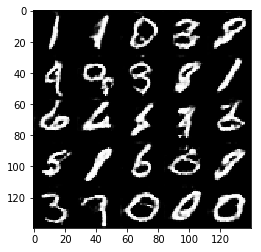

Epoch 2/2.. Steps 2010.. Discriminator Loss: 1.0666.. Generator Loss: 1.2760
Epoch 2/2.. Steps 2020.. Discriminator Loss: 0.9119.. Generator Loss: 1.3278
Epoch 2/2.. Steps 2030.. Discriminator Loss: 1.0706.. Generator Loss: 0.7694
Epoch 2/2.. Steps 2040.. Discriminator Loss: 0.7391.. Generator Loss: 1.3395
Epoch 2/2.. Steps 2050.. Discriminator Loss: 0.8257.. Generator Loss: 1.5041
Epoch 2/2.. Steps 2060.. Discriminator Loss: 0.8600.. Generator Loss: 1.1523
Epoch 2/2.. Steps 2070.. Discriminator Loss: 0.9485.. Generator Loss: 1.0161
Epoch 2/2.. Steps 2080.. Discriminator Loss: 1.2146.. Generator Loss: 0.6472
Epoch 2/2.. Steps 2090.. Discriminator Loss: 1.3265.. Generator Loss: 0.6196
Epoch 2/2.. Steps 2100.. Discriminator Loss: 1.1270.. Generator Loss: 0.8409


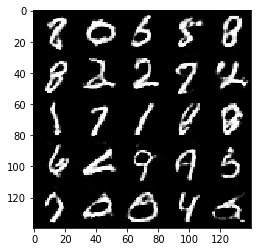

Epoch 2/2.. Steps 2110.. Discriminator Loss: 1.0588.. Generator Loss: 0.8747
Epoch 2/2.. Steps 2120.. Discriminator Loss: 3.7412.. Generator Loss: 5.7925
Epoch 2/2.. Steps 2130.. Discriminator Loss: 0.8486.. Generator Loss: 1.4623
Epoch 2/2.. Steps 2140.. Discriminator Loss: 1.1447.. Generator Loss: 1.8886
Epoch 2/2.. Steps 2150.. Discriminator Loss: 1.2754.. Generator Loss: 0.6093
Epoch 2/2.. Steps 2160.. Discriminator Loss: 1.2933.. Generator Loss: 0.5506
Epoch 2/2.. Steps 2170.. Discriminator Loss: 1.6072.. Generator Loss: 0.3979
Epoch 2/2.. Steps 2180.. Discriminator Loss: 0.9590.. Generator Loss: 1.0244
Epoch 2/2.. Steps 2190.. Discriminator Loss: 0.6863.. Generator Loss: 1.7993
Epoch 2/2.. Steps 2200.. Discriminator Loss: 0.9531.. Generator Loss: 1.1051


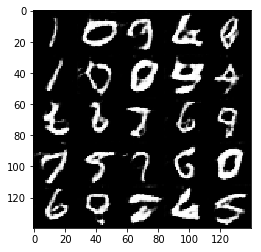

Epoch 2/2.. Steps 2210.. Discriminator Loss: 1.0040.. Generator Loss: 1.0126
Epoch 2/2.. Steps 2220.. Discriminator Loss: 1.1659.. Generator Loss: 2.4370
Epoch 2/2.. Steps 2230.. Discriminator Loss: 0.8492.. Generator Loss: 1.6892
Epoch 2/2.. Steps 2240.. Discriminator Loss: 0.7366.. Generator Loss: 1.4377
Epoch 2/2.. Steps 2250.. Discriminator Loss: 0.8761.. Generator Loss: 1.2193
Epoch 2/2.. Steps 2260.. Discriminator Loss: 0.7959.. Generator Loss: 1.8342
Epoch 2/2.. Steps 2270.. Discriminator Loss: 1.7825.. Generator Loss: 0.4087
Epoch 2/2.. Steps 2280.. Discriminator Loss: 0.8958.. Generator Loss: 1.4115
Epoch 2/2.. Steps 2290.. Discriminator Loss: 1.4206.. Generator Loss: 0.5922
Epoch 2/2.. Steps 2300.. Discriminator Loss: 0.9669.. Generator Loss: 2.4326


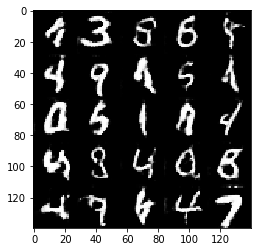

Epoch 2/2.. Steps 2310.. Discriminator Loss: 1.0462.. Generator Loss: 1.1181
Epoch 2/2.. Steps 2320.. Discriminator Loss: 0.9258.. Generator Loss: 0.9527
Epoch 2/2.. Steps 2330.. Discriminator Loss: 0.9142.. Generator Loss: 1.0617
Epoch 2/2.. Steps 2340.. Discriminator Loss: 0.8982.. Generator Loss: 1.5322
Epoch 2/2.. Steps 2350.. Discriminator Loss: 0.6543.. Generator Loss: 1.5785
Epoch 2/2.. Steps 2360.. Discriminator Loss: 0.7757.. Generator Loss: 1.5368
Epoch 2/2.. Steps 2370.. Discriminator Loss: 0.8940.. Generator Loss: 1.1691
Epoch 2/2.. Steps 2380.. Discriminator Loss: 0.8754.. Generator Loss: 1.4308
Epoch 2/2.. Steps 2390.. Discriminator Loss: 0.8046.. Generator Loss: 1.6237
Epoch 2/2.. Steps 2400.. Discriminator Loss: 0.7488.. Generator Loss: 1.3067


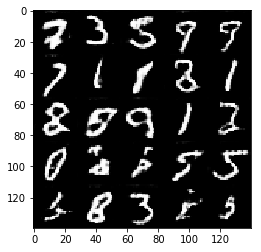

Epoch 2/2.. Steps 2410.. Discriminator Loss: 0.8596.. Generator Loss: 1.0884
Epoch 2/2.. Steps 2420.. Discriminator Loss: 0.6176.. Generator Loss: 1.8864
Epoch 2/2.. Steps 2430.. Discriminator Loss: 0.7734.. Generator Loss: 1.3117
Epoch 2/2.. Steps 2440.. Discriminator Loss: 0.9912.. Generator Loss: 0.8486
Epoch 2/2.. Steps 2450.. Discriminator Loss: 0.9190.. Generator Loss: 0.9597
Epoch 2/2.. Steps 2460.. Discriminator Loss: 1.2531.. Generator Loss: 0.7860
Epoch 2/2.. Steps 2470.. Discriminator Loss: 2.1610.. Generator Loss: 0.2402
Epoch 2/2.. Steps 2480.. Discriminator Loss: 0.7356.. Generator Loss: 1.6336
Epoch 2/2.. Steps 2490.. Discriminator Loss: 0.7291.. Generator Loss: 1.4315
Epoch 2/2.. Steps 2500.. Discriminator Loss: 1.3178.. Generator Loss: 0.6539


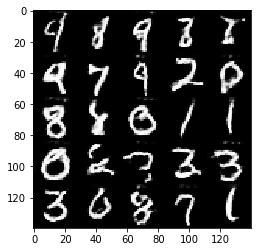

Epoch 2/2.. Steps 2510.. Discriminator Loss: 1.1531.. Generator Loss: 0.9158
Epoch 2/2.. Steps 2520.. Discriminator Loss: 0.8307.. Generator Loss: 1.1736
Epoch 2/2.. Steps 2530.. Discriminator Loss: 0.8147.. Generator Loss: 1.2194
Epoch 2/2.. Steps 2540.. Discriminator Loss: 1.6024.. Generator Loss: 0.4584
Epoch 2/2.. Steps 2550.. Discriminator Loss: 1.5818.. Generator Loss: 0.3959
Epoch 2/2.. Steps 2560.. Discriminator Loss: 1.1046.. Generator Loss: 0.8169
Epoch 2/2.. Steps 2570.. Discriminator Loss: 0.8270.. Generator Loss: 1.1969
Epoch 2/2.. Steps 2580.. Discriminator Loss: 1.1712.. Generator Loss: 0.7971
Epoch 2/2.. Steps 2590.. Discriminator Loss: 1.2475.. Generator Loss: 0.6537
Epoch 2/2.. Steps 2600.. Discriminator Loss: 0.6578.. Generator Loss: 1.7019


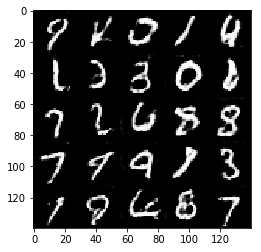

Epoch 2/2.. Steps 2610.. Discriminator Loss: 1.0976.. Generator Loss: 0.8074
Epoch 2/2.. Steps 2620.. Discriminator Loss: 0.7670.. Generator Loss: 1.2184
Epoch 2/2.. Steps 2630.. Discriminator Loss: 0.7056.. Generator Loss: 1.4171
Epoch 2/2.. Steps 2640.. Discriminator Loss: 1.8316.. Generator Loss: 0.4583
Epoch 2/2.. Steps 2650.. Discriminator Loss: 0.8969.. Generator Loss: 0.9801
Epoch 2/2.. Steps 2660.. Discriminator Loss: 0.7963.. Generator Loss: 1.8407
Epoch 2/2.. Steps 2670.. Discriminator Loss: 0.7929.. Generator Loss: 1.6264
Epoch 2/2.. Steps 2680.. Discriminator Loss: 0.7344.. Generator Loss: 1.8338
Epoch 2/2.. Steps 2690.. Discriminator Loss: 0.5240.. Generator Loss: 2.1385
Epoch 2/2.. Steps 2700.. Discriminator Loss: 1.4413.. Generator Loss: 2.2605


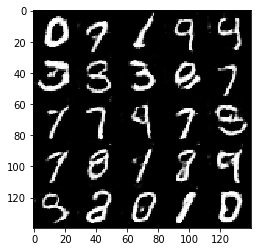

Epoch 2/2.. Steps 2710.. Discriminator Loss: 0.8443.. Generator Loss: 1.8814
Epoch 2/2.. Steps 2720.. Discriminator Loss: 0.8801.. Generator Loss: 1.2098
Epoch 2/2.. Steps 2730.. Discriminator Loss: 1.6978.. Generator Loss: 0.3684
Epoch 2/2.. Steps 2740.. Discriminator Loss: 0.7605.. Generator Loss: 1.4856
Epoch 2/2.. Steps 2750.. Discriminator Loss: 0.8447.. Generator Loss: 1.1317
Epoch 2/2.. Steps 2760.. Discriminator Loss: 0.9712.. Generator Loss: 1.7358
Epoch 2/2.. Steps 2770.. Discriminator Loss: 0.9226.. Generator Loss: 0.9880
Epoch 2/2.. Steps 2780.. Discriminator Loss: 0.7672.. Generator Loss: 1.8686
Epoch 2/2.. Steps 2790.. Discriminator Loss: 1.1066.. Generator Loss: 0.7737
Epoch 2/2.. Steps 2800.. Discriminator Loss: 1.3578.. Generator Loss: 0.5488


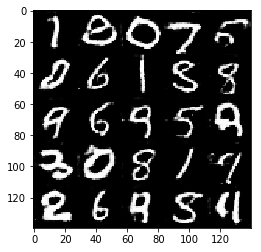

Epoch 2/2.. Steps 2810.. Discriminator Loss: 0.9008.. Generator Loss: 1.7523
Epoch 2/2.. Steps 2820.. Discriminator Loss: 0.7605.. Generator Loss: 1.8658
Epoch 2/2.. Steps 2830.. Discriminator Loss: 0.7060.. Generator Loss: 1.5609
Epoch 2/2.. Steps 2840.. Discriminator Loss: 1.5023.. Generator Loss: 0.5445
Epoch 2/2.. Steps 2850.. Discriminator Loss: 0.8623.. Generator Loss: 1.1864
Epoch 2/2.. Steps 2860.. Discriminator Loss: 0.9053.. Generator Loss: 1.8163
Epoch 2/2.. Steps 2870.. Discriminator Loss: 0.7854.. Generator Loss: 1.2622
Epoch 2/2.. Steps 2880.. Discriminator Loss: 0.8053.. Generator Loss: 1.1394
Epoch 2/2.. Steps 2890.. Discriminator Loss: 0.7798.. Generator Loss: 1.1589
Epoch 2/2.. Steps 2900.. Discriminator Loss: 1.4476.. Generator Loss: 3.5430


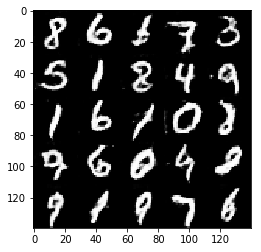

Epoch 2/2.. Steps 2910.. Discriminator Loss: 0.6641.. Generator Loss: 1.5976
Epoch 2/2.. Steps 2920.. Discriminator Loss: 0.8601.. Generator Loss: 1.0601
Epoch 2/2.. Steps 2930.. Discriminator Loss: 0.5704.. Generator Loss: 1.8237
Epoch 2/2.. Steps 2940.. Discriminator Loss: 0.8004.. Generator Loss: 1.6121
Epoch 2/2.. Steps 2950.. Discriminator Loss: 0.6412.. Generator Loss: 1.9214
Epoch 2/2.. Steps 2960.. Discriminator Loss: 0.6423.. Generator Loss: 1.8132
Epoch 2/2.. Steps 2970.. Discriminator Loss: 0.8453.. Generator Loss: 2.4695
Epoch 2/2.. Steps 2980.. Discriminator Loss: 1.8144.. Generator Loss: 0.3343
Epoch 2/2.. Steps 2990.. Discriminator Loss: 1.8348.. Generator Loss: 0.3416
Epoch 2/2.. Steps 3000.. Discriminator Loss: 1.0348.. Generator Loss: 0.9738


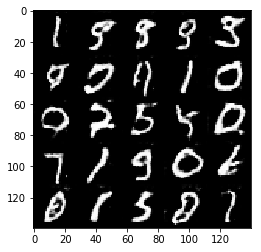

Epoch 2/2.. Steps 3010.. Discriminator Loss: 1.1631.. Generator Loss: 0.7242
Epoch 2/2.. Steps 3020.. Discriminator Loss: 0.6792.. Generator Loss: 1.7022
Epoch 2/2.. Steps 3030.. Discriminator Loss: 0.7228.. Generator Loss: 1.5775
Epoch 2/2.. Steps 3040.. Discriminator Loss: 1.2692.. Generator Loss: 0.7249
Epoch 2/2.. Steps 3050.. Discriminator Loss: 0.5381.. Generator Loss: 2.1136
Epoch 2/2.. Steps 3060.. Discriminator Loss: 0.9656.. Generator Loss: 0.9909
Epoch 2/2.. Steps 3070.. Discriminator Loss: 1.1104.. Generator Loss: 0.8085
Epoch 2/2.. Steps 3080.. Discriminator Loss: 0.6333.. Generator Loss: 1.7741
Epoch 2/2.. Steps 3090.. Discriminator Loss: 1.1945.. Generator Loss: 0.7750
Epoch 2/2.. Steps 3100.. Discriminator Loss: 2.1980.. Generator Loss: 0.3263


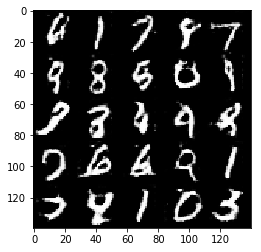

Epoch 2/2.. Steps 3110.. Discriminator Loss: 0.7868.. Generator Loss: 1.5717
Epoch 2/2.. Steps 3120.. Discriminator Loss: 0.6877.. Generator Loss: 1.7393
Epoch 2/2.. Steps 3130.. Discriminator Loss: 1.2526.. Generator Loss: 0.6540
Epoch 2/2.. Steps 3140.. Discriminator Loss: 1.6434.. Generator Loss: 0.5523
Epoch 2/2.. Steps 3150.. Discriminator Loss: 0.9107.. Generator Loss: 1.0725
Epoch 2/2.. Steps 3160.. Discriminator Loss: 1.5385.. Generator Loss: 0.5018
Epoch 2/2.. Steps 3170.. Discriminator Loss: 0.8091.. Generator Loss: 1.2963
Epoch 2/2.. Steps 3180.. Discriminator Loss: 1.0077.. Generator Loss: 0.9828
Epoch 2/2.. Steps 3190.. Discriminator Loss: 0.9915.. Generator Loss: 0.9495
Epoch 2/2.. Steps 3200.. Discriminator Loss: 0.8566.. Generator Loss: 1.0912


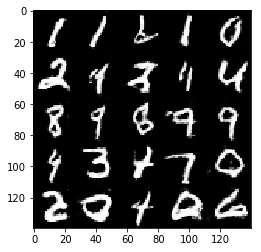

Epoch 2/2.. Steps 3210.. Discriminator Loss: 1.3606.. Generator Loss: 0.6413
Epoch 2/2.. Steps 3220.. Discriminator Loss: 1.0986.. Generator Loss: 0.9138
Epoch 2/2.. Steps 3230.. Discriminator Loss: 2.0573.. Generator Loss: 0.3755
Epoch 2/2.. Steps 3240.. Discriminator Loss: 2.0100.. Generator Loss: 4.3413
Epoch 2/2.. Steps 3250.. Discriminator Loss: 1.0925.. Generator Loss: 0.8241
Epoch 2/2.. Steps 3260.. Discriminator Loss: 0.7530.. Generator Loss: 1.5687
Epoch 2/2.. Steps 3270.. Discriminator Loss: 1.2712.. Generator Loss: 0.5932
Epoch 2/2.. Steps 3280.. Discriminator Loss: 1.0551.. Generator Loss: 1.7207
Epoch 2/2.. Steps 3290.. Discriminator Loss: 0.9199.. Generator Loss: 0.9797
Epoch 2/2.. Steps 3300.. Discriminator Loss: 0.6885.. Generator Loss: 1.7403


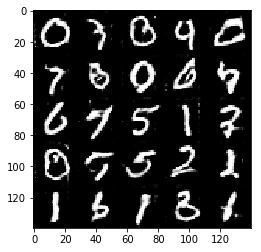

Epoch 2/2.. Steps 3310.. Discriminator Loss: 0.7583.. Generator Loss: 1.3884
Epoch 2/2.. Steps 3320.. Discriminator Loss: 0.5419.. Generator Loss: 2.2402
Epoch 2/2.. Steps 3330.. Discriminator Loss: 2.0003.. Generator Loss: 4.5755
Epoch 2/2.. Steps 3340.. Discriminator Loss: 0.7380.. Generator Loss: 1.5779
Epoch 2/2.. Steps 3350.. Discriminator Loss: 1.3018.. Generator Loss: 0.6203
Epoch 2/2.. Steps 3360.. Discriminator Loss: 0.6752.. Generator Loss: 2.0549
Epoch 2/2.. Steps 3370.. Discriminator Loss: 0.9741.. Generator Loss: 1.7911
Epoch 2/2.. Steps 3380.. Discriminator Loss: 0.6948.. Generator Loss: 1.6471
Epoch 2/2.. Steps 3390.. Discriminator Loss: 1.0133.. Generator Loss: 1.0717
Epoch 2/2.. Steps 3400.. Discriminator Loss: 1.3876.. Generator Loss: 0.5515


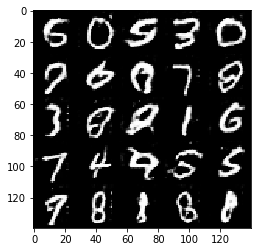

Epoch 2/2.. Steps 3410.. Discriminator Loss: 1.3794.. Generator Loss: 0.6482
Epoch 2/2.. Steps 3420.. Discriminator Loss: 0.7516.. Generator Loss: 1.8352
Epoch 2/2.. Steps 3430.. Discriminator Loss: 0.9356.. Generator Loss: 0.9509
Epoch 2/2.. Steps 3440.. Discriminator Loss: 0.9483.. Generator Loss: 1.0077
Epoch 2/2.. Steps 3450.. Discriminator Loss: 0.9016.. Generator Loss: 1.0835
Epoch 2/2.. Steps 3460.. Discriminator Loss: 1.1081.. Generator Loss: 0.7705
Epoch 2/2.. Steps 3470.. Discriminator Loss: 1.2248.. Generator Loss: 0.7278
Epoch 2/2.. Steps 3480.. Discriminator Loss: 0.7097.. Generator Loss: 1.5330
Epoch 2/2.. Steps 3490.. Discriminator Loss: 0.8134.. Generator Loss: 2.0202
Epoch 2/2.. Steps 3500.. Discriminator Loss: 1.5647.. Generator Loss: 0.5167


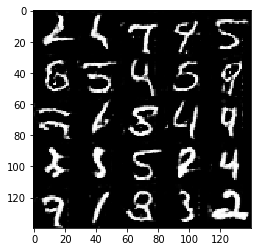

Epoch 2/2.. Steps 3510.. Discriminator Loss: 0.9238.. Generator Loss: 1.1342
Epoch 2/2.. Steps 3520.. Discriminator Loss: 0.6452.. Generator Loss: 1.8146
Epoch 2/2.. Steps 3530.. Discriminator Loss: 1.6324.. Generator Loss: 0.4098
Epoch 2/2.. Steps 3540.. Discriminator Loss: 0.7310.. Generator Loss: 1.4494
Epoch 2/2.. Steps 3550.. Discriminator Loss: 1.2433.. Generator Loss: 0.6688
Epoch 2/2.. Steps 3560.. Discriminator Loss: 0.8210.. Generator Loss: 1.2482
Epoch 2/2.. Steps 3570.. Discriminator Loss: 1.7897.. Generator Loss: 0.3404
Epoch 2/2.. Steps 3580.. Discriminator Loss: 0.6030.. Generator Loss: 1.8337
Epoch 2/2.. Steps 3590.. Discriminator Loss: 0.6342.. Generator Loss: 1.7851
Epoch 2/2.. Steps 3600.. Discriminator Loss: 0.7720.. Generator Loss: 1.9151


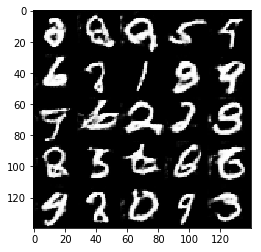

Epoch 2/2.. Steps 3610.. Discriminator Loss: 0.6052.. Generator Loss: 2.0792
Epoch 2/2.. Steps 3620.. Discriminator Loss: 1.1959.. Generator Loss: 2.1978
Epoch 2/2.. Steps 3630.. Discriminator Loss: 0.8283.. Generator Loss: 1.1921
Epoch 2/2.. Steps 3640.. Discriminator Loss: 0.7854.. Generator Loss: 1.1979
Epoch 2/2.. Steps 3650.. Discriminator Loss: 1.3723.. Generator Loss: 0.6122
Epoch 2/2.. Steps 3660.. Discriminator Loss: 0.7648.. Generator Loss: 1.5078
Epoch 2/2.. Steps 3670.. Discriminator Loss: 0.7159.. Generator Loss: 1.4397
Epoch 2/2.. Steps 3680.. Discriminator Loss: 0.8409.. Generator Loss: 1.3080
Epoch 2/2.. Steps 3690.. Discriminator Loss: 0.9640.. Generator Loss: 0.9143
Epoch 2/2.. Steps 3700.. Discriminator Loss: 0.8992.. Generator Loss: 1.1385


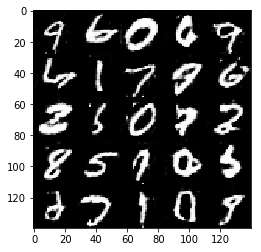

Epoch 2/2.. Steps 3710.. Discriminator Loss: 0.8303.. Generator Loss: 2.4424
Epoch 2/2.. Steps 3720.. Discriminator Loss: 1.8400.. Generator Loss: 0.4059
Epoch 2/2.. Steps 3730.. Discriminator Loss: 0.8188.. Generator Loss: 1.1980
Epoch 2/2.. Steps 3740.. Discriminator Loss: 0.9898.. Generator Loss: 0.8932
Epoch 2/2.. Steps 3750.. Discriminator Loss: 0.7131.. Generator Loss: 1.4501


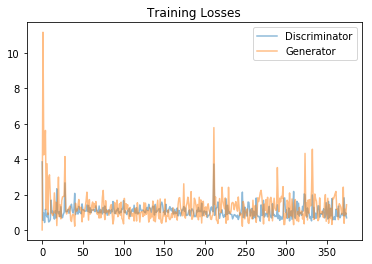

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1.. Steps 10.. Discriminator Loss: 6.3781.. Generator Loss: 0.0031
Epoch 1/1.. Steps 20.. Discriminator Loss: 1.1140.. Generator Loss: 2.9487
Epoch 1/1.. Steps 30.. Discriminator Loss: 1.2674.. Generator Loss: 14.0596
Epoch 1/1.. Steps 40.. Discriminator Loss: 1.6637.. Generator Loss: 0.3636
Epoch 1/1.. Steps 50.. Discriminator Loss: 1.3747.. Generator Loss: 0.5062
Epoch 1/1.. Steps 60.. Discriminator Loss: 0.6455.. Generator Loss: 2.1854
Epoch 1/1.. Steps 70.. Discriminator Loss: 0.6152.. Generator Loss: 2.4559
Epoch 1/1.. Steps 80.. Discriminator Loss: 0.7221.. Generator Loss: 1.8561
Epoch 1/1.. Steps 90.. Discriminator Loss: 0.9849.. Generator Loss: 1.1864
Epoch 1/1.. Steps 100.. Discriminator Loss: 1.1649.. Generator Loss: 1.5483


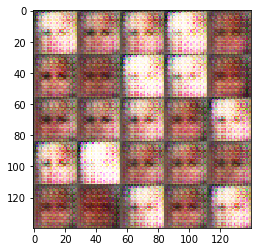

Epoch 1/1.. Steps 110.. Discriminator Loss: 1.1337.. Generator Loss: 3.5405
Epoch 1/1.. Steps 120.. Discriminator Loss: 1.5002.. Generator Loss: 3.6242
Epoch 1/1.. Steps 130.. Discriminator Loss: 0.7323.. Generator Loss: 1.5320
Epoch 1/1.. Steps 140.. Discriminator Loss: 0.7185.. Generator Loss: 1.5488
Epoch 1/1.. Steps 150.. Discriminator Loss: 1.2321.. Generator Loss: 0.8912
Epoch 1/1.. Steps 160.. Discriminator Loss: 0.8962.. Generator Loss: 1.8613
Epoch 1/1.. Steps 170.. Discriminator Loss: 1.2423.. Generator Loss: 0.8785
Epoch 1/1.. Steps 180.. Discriminator Loss: 1.0113.. Generator Loss: 0.9615
Epoch 1/1.. Steps 190.. Discriminator Loss: 1.2734.. Generator Loss: 0.6879
Epoch 1/1.. Steps 200.. Discriminator Loss: 1.3486.. Generator Loss: 0.9578


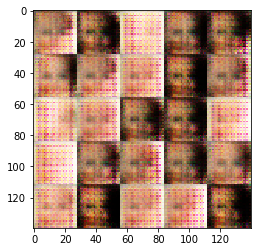

Epoch 1/1.. Steps 210.. Discriminator Loss: 0.8702.. Generator Loss: 1.4743
Epoch 1/1.. Steps 220.. Discriminator Loss: 1.1223.. Generator Loss: 1.5519
Epoch 1/1.. Steps 230.. Discriminator Loss: 1.3016.. Generator Loss: 0.7407
Epoch 1/1.. Steps 240.. Discriminator Loss: 1.5810.. Generator Loss: 0.6941
Epoch 1/1.. Steps 250.. Discriminator Loss: 1.4081.. Generator Loss: 0.6462
Epoch 1/1.. Steps 260.. Discriminator Loss: 0.6455.. Generator Loss: 2.0592
Epoch 1/1.. Steps 270.. Discriminator Loss: 1.0386.. Generator Loss: 1.3890
Epoch 1/1.. Steps 280.. Discriminator Loss: 0.8137.. Generator Loss: 1.7336
Epoch 1/1.. Steps 290.. Discriminator Loss: 0.7494.. Generator Loss: 1.9143
Epoch 1/1.. Steps 300.. Discriminator Loss: 1.0287.. Generator Loss: 1.3739


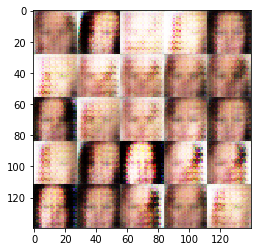

Epoch 1/1.. Steps 310.. Discriminator Loss: 1.6186.. Generator Loss: 0.4888
Epoch 1/1.. Steps 320.. Discriminator Loss: 1.0424.. Generator Loss: 1.8413
Epoch 1/1.. Steps 330.. Discriminator Loss: 1.1651.. Generator Loss: 1.9346
Epoch 1/1.. Steps 340.. Discriminator Loss: 1.8789.. Generator Loss: 0.4063
Epoch 1/1.. Steps 350.. Discriminator Loss: 1.1295.. Generator Loss: 0.8899
Epoch 1/1.. Steps 360.. Discriminator Loss: 1.5918.. Generator Loss: 0.5067
Epoch 1/1.. Steps 370.. Discriminator Loss: 1.7883.. Generator Loss: 0.3517
Epoch 1/1.. Steps 380.. Discriminator Loss: 1.4031.. Generator Loss: 0.5756
Epoch 1/1.. Steps 390.. Discriminator Loss: 2.0203.. Generator Loss: 0.3783
Epoch 1/1.. Steps 400.. Discriminator Loss: 0.8533.. Generator Loss: 1.3516


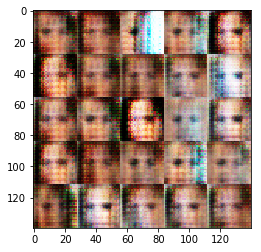

Epoch 1/1.. Steps 410.. Discriminator Loss: 1.1230.. Generator Loss: 0.7058
Epoch 1/1.. Steps 420.. Discriminator Loss: 1.1809.. Generator Loss: 1.0937
Epoch 1/1.. Steps 430.. Discriminator Loss: 1.2347.. Generator Loss: 0.6195
Epoch 1/1.. Steps 440.. Discriminator Loss: 1.3571.. Generator Loss: 1.1422
Epoch 1/1.. Steps 450.. Discriminator Loss: 1.2703.. Generator Loss: 1.1360
Epoch 1/1.. Steps 460.. Discriminator Loss: 0.8585.. Generator Loss: 1.5222
Epoch 1/1.. Steps 470.. Discriminator Loss: 1.2047.. Generator Loss: 0.8786
Epoch 1/1.. Steps 480.. Discriminator Loss: 1.0472.. Generator Loss: 1.1276
Epoch 1/1.. Steps 490.. Discriminator Loss: 1.6593.. Generator Loss: 2.4581
Epoch 1/1.. Steps 500.. Discriminator Loss: 1.0665.. Generator Loss: 2.5721


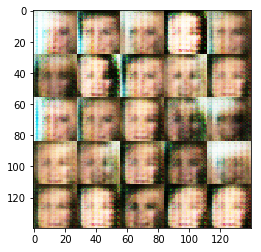

Epoch 1/1.. Steps 510.. Discriminator Loss: 1.2302.. Generator Loss: 0.7591
Epoch 1/1.. Steps 520.. Discriminator Loss: 1.1031.. Generator Loss: 0.8976
Epoch 1/1.. Steps 530.. Discriminator Loss: 1.0229.. Generator Loss: 1.1585
Epoch 1/1.. Steps 540.. Discriminator Loss: 0.8614.. Generator Loss: 1.6764
Epoch 1/1.. Steps 550.. Discriminator Loss: 1.1497.. Generator Loss: 0.9160
Epoch 1/1.. Steps 560.. Discriminator Loss: 0.8195.. Generator Loss: 1.5677
Epoch 1/1.. Steps 570.. Discriminator Loss: 1.1271.. Generator Loss: 0.7255
Epoch 1/1.. Steps 580.. Discriminator Loss: 0.9574.. Generator Loss: 1.0793
Epoch 1/1.. Steps 590.. Discriminator Loss: 1.1176.. Generator Loss: 1.2457
Epoch 1/1.. Steps 600.. Discriminator Loss: 1.1642.. Generator Loss: 0.7475


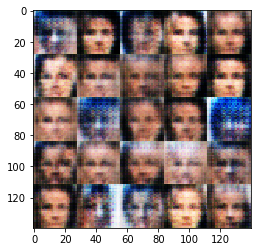

Epoch 1/1.. Steps 610.. Discriminator Loss: 0.8415.. Generator Loss: 1.3658
Epoch 1/1.. Steps 620.. Discriminator Loss: 0.8322.. Generator Loss: 2.0288
Epoch 1/1.. Steps 630.. Discriminator Loss: 1.0755.. Generator Loss: 1.6963
Epoch 1/1.. Steps 640.. Discriminator Loss: 0.9316.. Generator Loss: 1.0009
Epoch 1/1.. Steps 650.. Discriminator Loss: 0.9253.. Generator Loss: 1.4169
Epoch 1/1.. Steps 660.. Discriminator Loss: 1.1562.. Generator Loss: 1.3876
Epoch 1/1.. Steps 670.. Discriminator Loss: 1.5744.. Generator Loss: 0.4909
Epoch 1/1.. Steps 680.. Discriminator Loss: 1.2773.. Generator Loss: 2.8604
Epoch 1/1.. Steps 690.. Discriminator Loss: 0.9567.. Generator Loss: 1.4290
Epoch 1/1.. Steps 700.. Discriminator Loss: 0.9371.. Generator Loss: 3.0137


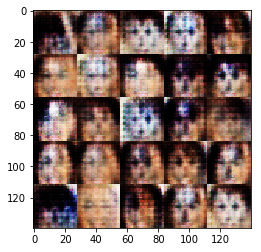

Epoch 1/1.. Steps 710.. Discriminator Loss: 0.9168.. Generator Loss: 0.9248
Epoch 1/1.. Steps 720.. Discriminator Loss: 1.4494.. Generator Loss: 3.2759
Epoch 1/1.. Steps 730.. Discriminator Loss: 0.9871.. Generator Loss: 1.3579
Epoch 1/1.. Steps 740.. Discriminator Loss: 1.2283.. Generator Loss: 0.8919
Epoch 1/1.. Steps 750.. Discriminator Loss: 1.2635.. Generator Loss: 1.0300
Epoch 1/1.. Steps 760.. Discriminator Loss: 0.9982.. Generator Loss: 1.4374
Epoch 1/1.. Steps 770.. Discriminator Loss: 1.3801.. Generator Loss: 0.9785
Epoch 1/1.. Steps 780.. Discriminator Loss: 0.9746.. Generator Loss: 1.3946
Epoch 1/1.. Steps 790.. Discriminator Loss: 1.1098.. Generator Loss: 2.4838
Epoch 1/1.. Steps 800.. Discriminator Loss: 0.9652.. Generator Loss: 1.1554


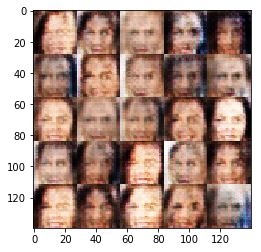

Epoch 1/1.. Steps 810.. Discriminator Loss: 0.8564.. Generator Loss: 1.7931
Epoch 1/1.. Steps 820.. Discriminator Loss: 1.2742.. Generator Loss: 0.7559
Epoch 1/1.. Steps 830.. Discriminator Loss: 0.8257.. Generator Loss: 1.2898
Epoch 1/1.. Steps 840.. Discriminator Loss: 1.1219.. Generator Loss: 1.0718
Epoch 1/1.. Steps 850.. Discriminator Loss: 0.9553.. Generator Loss: 1.2316
Epoch 1/1.. Steps 860.. Discriminator Loss: 1.1135.. Generator Loss: 1.5486
Epoch 1/1.. Steps 870.. Discriminator Loss: 0.8673.. Generator Loss: 1.1104
Epoch 1/1.. Steps 880.. Discriminator Loss: 1.9352.. Generator Loss: 2.8123
Epoch 1/1.. Steps 890.. Discriminator Loss: 1.2135.. Generator Loss: 1.2679
Epoch 1/1.. Steps 900.. Discriminator Loss: 1.1907.. Generator Loss: 1.0844


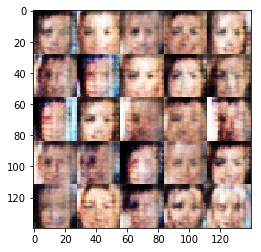

Epoch 1/1.. Steps 910.. Discriminator Loss: 0.8669.. Generator Loss: 1.5348
Epoch 1/1.. Steps 920.. Discriminator Loss: 1.3628.. Generator Loss: 3.7438
Epoch 1/1.. Steps 930.. Discriminator Loss: 0.9950.. Generator Loss: 1.6786
Epoch 1/1.. Steps 940.. Discriminator Loss: 1.1484.. Generator Loss: 0.7728
Epoch 1/1.. Steps 950.. Discriminator Loss: 1.0271.. Generator Loss: 1.6654
Epoch 1/1.. Steps 960.. Discriminator Loss: 1.5151.. Generator Loss: 0.4811
Epoch 1/1.. Steps 970.. Discriminator Loss: 0.8295.. Generator Loss: 1.1488
Epoch 1/1.. Steps 980.. Discriminator Loss: 1.0969.. Generator Loss: 1.3304
Epoch 1/1.. Steps 990.. Discriminator Loss: 1.0034.. Generator Loss: 1.1835
Epoch 1/1.. Steps 1000.. Discriminator Loss: 1.1733.. Generator Loss: 1.2474


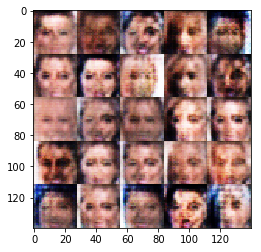

Epoch 1/1.. Steps 1010.. Discriminator Loss: 0.8809.. Generator Loss: 1.4872
Epoch 1/1.. Steps 1020.. Discriminator Loss: 1.2007.. Generator Loss: 0.9525
Epoch 1/1.. Steps 1030.. Discriminator Loss: 1.1745.. Generator Loss: 0.8876
Epoch 1/1.. Steps 1040.. Discriminator Loss: 1.1123.. Generator Loss: 1.2687
Epoch 1/1.. Steps 1050.. Discriminator Loss: 1.4252.. Generator Loss: 0.8065
Epoch 1/1.. Steps 1060.. Discriminator Loss: 1.2134.. Generator Loss: 1.1845
Epoch 1/1.. Steps 1070.. Discriminator Loss: 1.1265.. Generator Loss: 0.8483
Epoch 1/1.. Steps 1080.. Discriminator Loss: 1.2153.. Generator Loss: 0.8747
Epoch 1/1.. Steps 1090.. Discriminator Loss: 1.0601.. Generator Loss: 1.5394
Epoch 1/1.. Steps 1100.. Discriminator Loss: 0.8445.. Generator Loss: 1.6029


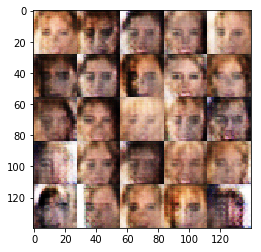

Epoch 1/1.. Steps 1110.. Discriminator Loss: 1.0214.. Generator Loss: 0.8929
Epoch 1/1.. Steps 1120.. Discriminator Loss: 1.0783.. Generator Loss: 1.5002
Epoch 1/1.. Steps 1130.. Discriminator Loss: 1.0246.. Generator Loss: 2.9529
Epoch 1/1.. Steps 1140.. Discriminator Loss: 1.6174.. Generator Loss: 1.1975
Epoch 1/1.. Steps 1150.. Discriminator Loss: 1.2797.. Generator Loss: 0.5936
Epoch 1/1.. Steps 1160.. Discriminator Loss: 0.9349.. Generator Loss: 1.2307
Epoch 1/1.. Steps 1170.. Discriminator Loss: 1.0768.. Generator Loss: 1.4578
Epoch 1/1.. Steps 1180.. Discriminator Loss: 0.9653.. Generator Loss: 1.6097
Epoch 1/1.. Steps 1190.. Discriminator Loss: 1.0651.. Generator Loss: 1.2500
Epoch 1/1.. Steps 1200.. Discriminator Loss: 1.7383.. Generator Loss: 0.4664


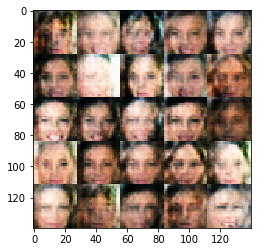

Epoch 1/1.. Steps 1210.. Discriminator Loss: 1.0609.. Generator Loss: 1.4971
Epoch 1/1.. Steps 1220.. Discriminator Loss: 1.0340.. Generator Loss: 1.1631
Epoch 1/1.. Steps 1230.. Discriminator Loss: 1.2030.. Generator Loss: 1.2648
Epoch 1/1.. Steps 1240.. Discriminator Loss: 0.7745.. Generator Loss: 1.5023
Epoch 1/1.. Steps 1250.. Discriminator Loss: 0.8839.. Generator Loss: 1.1223
Epoch 1/1.. Steps 1260.. Discriminator Loss: 1.1692.. Generator Loss: 0.8121
Epoch 1/1.. Steps 1270.. Discriminator Loss: 0.9392.. Generator Loss: 1.5387
Epoch 1/1.. Steps 1280.. Discriminator Loss: 0.9220.. Generator Loss: 1.3907
Epoch 1/1.. Steps 1290.. Discriminator Loss: 1.3067.. Generator Loss: 0.7799
Epoch 1/1.. Steps 1300.. Discriminator Loss: 1.1973.. Generator Loss: 0.9440


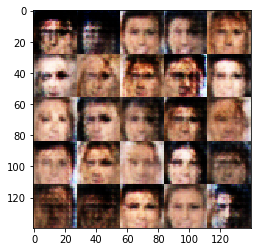

Epoch 1/1.. Steps 1310.. Discriminator Loss: 1.0766.. Generator Loss: 1.0536
Epoch 1/1.. Steps 1320.. Discriminator Loss: 0.9423.. Generator Loss: 1.3369
Epoch 1/1.. Steps 1330.. Discriminator Loss: 1.2877.. Generator Loss: 0.8034
Epoch 1/1.. Steps 1340.. Discriminator Loss: 1.1950.. Generator Loss: 0.7611
Epoch 1/1.. Steps 1350.. Discriminator Loss: 1.1208.. Generator Loss: 2.2861
Epoch 1/1.. Steps 1360.. Discriminator Loss: 0.8719.. Generator Loss: 1.1180
Epoch 1/1.. Steps 1370.. Discriminator Loss: 1.1873.. Generator Loss: 1.1675
Epoch 1/1.. Steps 1380.. Discriminator Loss: 1.0432.. Generator Loss: 0.8842
Epoch 1/1.. Steps 1390.. Discriminator Loss: 0.9938.. Generator Loss: 1.2292
Epoch 1/1.. Steps 1400.. Discriminator Loss: 1.3922.. Generator Loss: 0.6313


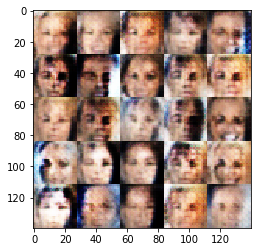

Epoch 1/1.. Steps 1410.. Discriminator Loss: 1.0401.. Generator Loss: 1.0285
Epoch 1/1.. Steps 1420.. Discriminator Loss: 1.2203.. Generator Loss: 1.6692
Epoch 1/1.. Steps 1430.. Discriminator Loss: 0.9015.. Generator Loss: 1.2260
Epoch 1/1.. Steps 1440.. Discriminator Loss: 0.9283.. Generator Loss: 1.4237
Epoch 1/1.. Steps 1450.. Discriminator Loss: 1.0053.. Generator Loss: 0.9972
Epoch 1/1.. Steps 1460.. Discriminator Loss: 1.2161.. Generator Loss: 1.7993
Epoch 1/1.. Steps 1470.. Discriminator Loss: 0.9069.. Generator Loss: 1.9315
Epoch 1/1.. Steps 1480.. Discriminator Loss: 0.9479.. Generator Loss: 1.1961
Epoch 1/1.. Steps 1490.. Discriminator Loss: 0.9722.. Generator Loss: 0.9797
Epoch 1/1.. Steps 1500.. Discriminator Loss: 1.0298.. Generator Loss: 1.2149


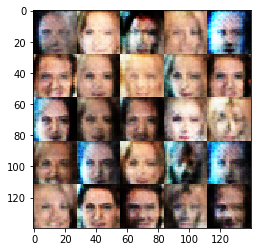

Epoch 1/1.. Steps 1510.. Discriminator Loss: 0.9731.. Generator Loss: 1.5596
Epoch 1/1.. Steps 1520.. Discriminator Loss: 1.8398.. Generator Loss: 0.3350
Epoch 1/1.. Steps 1530.. Discriminator Loss: 1.0491.. Generator Loss: 1.7607
Epoch 1/1.. Steps 1540.. Discriminator Loss: 0.8653.. Generator Loss: 1.2340
Epoch 1/1.. Steps 1550.. Discriminator Loss: 0.8323.. Generator Loss: 1.2121
Epoch 1/1.. Steps 1560.. Discriminator Loss: 0.8627.. Generator Loss: 2.1785
Epoch 1/1.. Steps 1570.. Discriminator Loss: 1.3218.. Generator Loss: 0.6357
Epoch 1/1.. Steps 1580.. Discriminator Loss: 1.1437.. Generator Loss: 0.8191
Epoch 1/1.. Steps 1590.. Discriminator Loss: 1.0630.. Generator Loss: 1.0004
Epoch 1/1.. Steps 1600.. Discriminator Loss: 1.1827.. Generator Loss: 0.7328


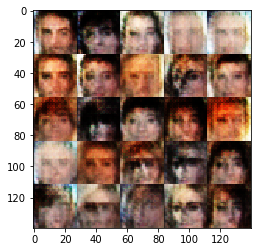

Epoch 1/1.. Steps 1610.. Discriminator Loss: 1.0102.. Generator Loss: 1.7030
Epoch 1/1.. Steps 1620.. Discriminator Loss: 1.0871.. Generator Loss: 0.8424
Epoch 1/1.. Steps 1630.. Discriminator Loss: 1.0889.. Generator Loss: 1.4875
Epoch 1/1.. Steps 1640.. Discriminator Loss: 1.2981.. Generator Loss: 0.6218
Epoch 1/1.. Steps 1650.. Discriminator Loss: 1.3631.. Generator Loss: 0.6589
Epoch 1/1.. Steps 1660.. Discriminator Loss: 1.0866.. Generator Loss: 1.8602
Epoch 1/1.. Steps 1670.. Discriminator Loss: 1.0882.. Generator Loss: 1.6115
Epoch 1/1.. Steps 1680.. Discriminator Loss: 1.2242.. Generator Loss: 0.6847
Epoch 1/1.. Steps 1690.. Discriminator Loss: 1.2909.. Generator Loss: 1.6772
Epoch 1/1.. Steps 1700.. Discriminator Loss: 1.0484.. Generator Loss: 1.3432


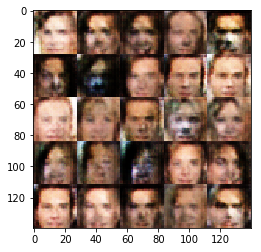

Epoch 1/1.. Steps 1710.. Discriminator Loss: 1.0318.. Generator Loss: 1.6459
Epoch 1/1.. Steps 1720.. Discriminator Loss: 0.9752.. Generator Loss: 1.4314
Epoch 1/1.. Steps 1730.. Discriminator Loss: 1.0414.. Generator Loss: 0.9969
Epoch 1/1.. Steps 1740.. Discriminator Loss: 1.1398.. Generator Loss: 1.0067
Epoch 1/1.. Steps 1750.. Discriminator Loss: 0.9810.. Generator Loss: 1.0541
Epoch 1/1.. Steps 1760.. Discriminator Loss: 1.0858.. Generator Loss: 0.9645
Epoch 1/1.. Steps 1770.. Discriminator Loss: 1.0599.. Generator Loss: 1.1312
Epoch 1/1.. Steps 1780.. Discriminator Loss: 1.0287.. Generator Loss: 1.2915
Epoch 1/1.. Steps 1790.. Discriminator Loss: 0.8868.. Generator Loss: 1.2123
Epoch 1/1.. Steps 1800.. Discriminator Loss: 1.0230.. Generator Loss: 1.8289


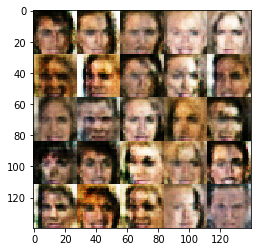

Epoch 1/1.. Steps 1810.. Discriminator Loss: 0.7657.. Generator Loss: 1.6180
Epoch 1/1.. Steps 1820.. Discriminator Loss: 0.8411.. Generator Loss: 1.3076
Epoch 1/1.. Steps 1830.. Discriminator Loss: 1.4005.. Generator Loss: 0.6161
Epoch 1/1.. Steps 1840.. Discriminator Loss: 1.0030.. Generator Loss: 1.1001
Epoch 1/1.. Steps 1850.. Discriminator Loss: 0.9903.. Generator Loss: 1.1680
Epoch 1/1.. Steps 1860.. Discriminator Loss: 0.9946.. Generator Loss: 1.2959
Epoch 1/1.. Steps 1870.. Discriminator Loss: 0.8897.. Generator Loss: 1.1456
Epoch 1/1.. Steps 1880.. Discriminator Loss: 0.9241.. Generator Loss: 1.1519
Epoch 1/1.. Steps 1890.. Discriminator Loss: 0.9784.. Generator Loss: 1.4930
Epoch 1/1.. Steps 1900.. Discriminator Loss: 1.1171.. Generator Loss: 0.9579


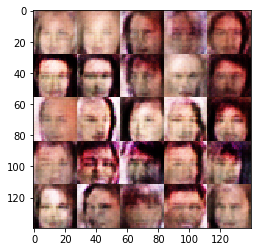

Epoch 1/1.. Steps 1910.. Discriminator Loss: 1.2412.. Generator Loss: 0.7413
Epoch 1/1.. Steps 1920.. Discriminator Loss: 1.0623.. Generator Loss: 0.8126
Epoch 1/1.. Steps 1930.. Discriminator Loss: 1.0151.. Generator Loss: 1.1785
Epoch 1/1.. Steps 1940.. Discriminator Loss: 1.0972.. Generator Loss: 0.8829
Epoch 1/1.. Steps 1950.. Discriminator Loss: 1.0595.. Generator Loss: 0.9061
Epoch 1/1.. Steps 1960.. Discriminator Loss: 1.0822.. Generator Loss: 2.0451
Epoch 1/1.. Steps 1970.. Discriminator Loss: 1.0276.. Generator Loss: 1.0481
Epoch 1/1.. Steps 1980.. Discriminator Loss: 1.0473.. Generator Loss: 0.8729
Epoch 1/1.. Steps 1990.. Discriminator Loss: 0.8909.. Generator Loss: 1.2573
Epoch 1/1.. Steps 2000.. Discriminator Loss: 1.0075.. Generator Loss: 1.4413


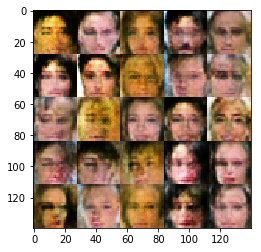

Epoch 1/1.. Steps 2010.. Discriminator Loss: 1.1287.. Generator Loss: 1.5680
Epoch 1/1.. Steps 2020.. Discriminator Loss: 1.3356.. Generator Loss: 0.5947
Epoch 1/1.. Steps 2030.. Discriminator Loss: 0.9144.. Generator Loss: 1.5251
Epoch 1/1.. Steps 2040.. Discriminator Loss: 0.9179.. Generator Loss: 1.0830
Epoch 1/1.. Steps 2050.. Discriminator Loss: 1.0986.. Generator Loss: 0.9843
Epoch 1/1.. Steps 2060.. Discriminator Loss: 0.9211.. Generator Loss: 1.3089
Epoch 1/1.. Steps 2070.. Discriminator Loss: 1.2544.. Generator Loss: 1.1085
Epoch 1/1.. Steps 2080.. Discriminator Loss: 0.9598.. Generator Loss: 1.4611
Epoch 1/1.. Steps 2090.. Discriminator Loss: 0.8511.. Generator Loss: 1.3674
Epoch 1/1.. Steps 2100.. Discriminator Loss: 1.1446.. Generator Loss: 0.8851


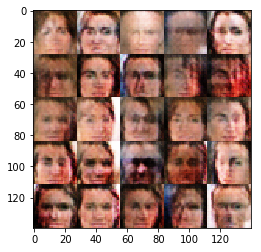

Epoch 1/1.. Steps 2110.. Discriminator Loss: 0.8984.. Generator Loss: 2.0325
Epoch 1/1.. Steps 2120.. Discriminator Loss: 0.9954.. Generator Loss: 2.0774
Epoch 1/1.. Steps 2130.. Discriminator Loss: 0.9747.. Generator Loss: 1.0307
Epoch 1/1.. Steps 2140.. Discriminator Loss: 0.9664.. Generator Loss: 1.0208
Epoch 1/1.. Steps 2150.. Discriminator Loss: 1.0552.. Generator Loss: 1.0719
Epoch 1/1.. Steps 2160.. Discriminator Loss: 0.9058.. Generator Loss: 1.8262
Epoch 1/1.. Steps 2170.. Discriminator Loss: 1.1095.. Generator Loss: 0.8401
Epoch 1/1.. Steps 2180.. Discriminator Loss: 0.9508.. Generator Loss: 1.8729
Epoch 1/1.. Steps 2190.. Discriminator Loss: 1.0928.. Generator Loss: 1.2868
Epoch 1/1.. Steps 2200.. Discriminator Loss: 0.9575.. Generator Loss: 1.0432


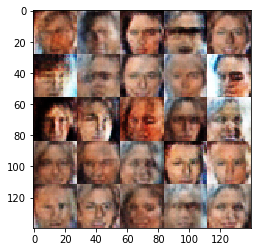

Epoch 1/1.. Steps 2210.. Discriminator Loss: 0.9733.. Generator Loss: 1.1114
Epoch 1/1.. Steps 2220.. Discriminator Loss: 1.0396.. Generator Loss: 1.0051
Epoch 1/1.. Steps 2230.. Discriminator Loss: 1.1016.. Generator Loss: 0.7812
Epoch 1/1.. Steps 2240.. Discriminator Loss: 1.1454.. Generator Loss: 0.8552
Epoch 1/1.. Steps 2250.. Discriminator Loss: 1.0412.. Generator Loss: 1.0624
Epoch 1/1.. Steps 2260.. Discriminator Loss: 1.0462.. Generator Loss: 1.2974
Epoch 1/1.. Steps 2270.. Discriminator Loss: 1.2166.. Generator Loss: 0.7018
Epoch 1/1.. Steps 2280.. Discriminator Loss: 1.0205.. Generator Loss: 1.0791
Epoch 1/1.. Steps 2290.. Discriminator Loss: 0.9001.. Generator Loss: 2.0901
Epoch 1/1.. Steps 2300.. Discriminator Loss: 1.2208.. Generator Loss: 1.9812


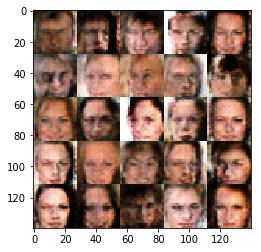

Epoch 1/1.. Steps 2310.. Discriminator Loss: 1.0021.. Generator Loss: 1.6259
Epoch 1/1.. Steps 2320.. Discriminator Loss: 1.2009.. Generator Loss: 3.0873
Epoch 1/1.. Steps 2330.. Discriminator Loss: 1.2219.. Generator Loss: 0.7175
Epoch 1/1.. Steps 2340.. Discriminator Loss: 1.3014.. Generator Loss: 0.6028
Epoch 1/1.. Steps 2350.. Discriminator Loss: 1.1099.. Generator Loss: 1.2615
Epoch 1/1.. Steps 2360.. Discriminator Loss: 1.1126.. Generator Loss: 0.8223
Epoch 1/1.. Steps 2370.. Discriminator Loss: 1.0593.. Generator Loss: 1.5249
Epoch 1/1.. Steps 2380.. Discriminator Loss: 0.9379.. Generator Loss: 1.1553
Epoch 1/1.. Steps 2390.. Discriminator Loss: 0.9857.. Generator Loss: 2.0308
Epoch 1/1.. Steps 2400.. Discriminator Loss: 0.9305.. Generator Loss: 1.0790


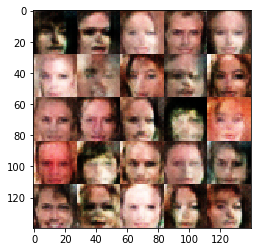

Epoch 1/1.. Steps 2410.. Discriminator Loss: 1.0292.. Generator Loss: 1.1093
Epoch 1/1.. Steps 2420.. Discriminator Loss: 1.0619.. Generator Loss: 0.9384
Epoch 1/1.. Steps 2430.. Discriminator Loss: 1.1355.. Generator Loss: 0.8646
Epoch 1/1.. Steps 2440.. Discriminator Loss: 1.1942.. Generator Loss: 1.2039
Epoch 1/1.. Steps 2450.. Discriminator Loss: 1.0336.. Generator Loss: 1.0746
Epoch 1/1.. Steps 2460.. Discriminator Loss: 1.1915.. Generator Loss: 1.6642
Epoch 1/1.. Steps 2470.. Discriminator Loss: 1.2035.. Generator Loss: 0.7129
Epoch 1/1.. Steps 2480.. Discriminator Loss: 0.9965.. Generator Loss: 1.4464
Epoch 1/1.. Steps 2490.. Discriminator Loss: 0.9626.. Generator Loss: 1.3426
Epoch 1/1.. Steps 2500.. Discriminator Loss: 1.0777.. Generator Loss: 1.2213


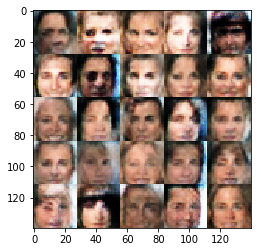

Epoch 1/1.. Steps 2510.. Discriminator Loss: 0.9793.. Generator Loss: 1.6698
Epoch 1/1.. Steps 2520.. Discriminator Loss: 1.1133.. Generator Loss: 0.8454
Epoch 1/1.. Steps 2530.. Discriminator Loss: 1.5145.. Generator Loss: 0.5159
Epoch 1/1.. Steps 2540.. Discriminator Loss: 1.1626.. Generator Loss: 1.1714
Epoch 1/1.. Steps 2550.. Discriminator Loss: 1.1131.. Generator Loss: 0.8358
Epoch 1/1.. Steps 2560.. Discriminator Loss: 1.1624.. Generator Loss: 0.7478
Epoch 1/1.. Steps 2570.. Discriminator Loss: 1.2631.. Generator Loss: 1.9030
Epoch 1/1.. Steps 2580.. Discriminator Loss: 1.0249.. Generator Loss: 1.3540
Epoch 1/1.. Steps 2590.. Discriminator Loss: 1.1793.. Generator Loss: 0.7418
Epoch 1/1.. Steps 2600.. Discriminator Loss: 1.0278.. Generator Loss: 1.1459


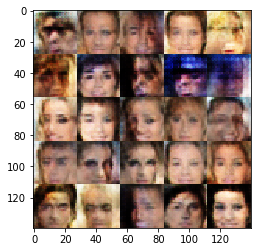

Epoch 1/1.. Steps 2610.. Discriminator Loss: 1.1380.. Generator Loss: 1.7130
Epoch 1/1.. Steps 2620.. Discriminator Loss: 1.1439.. Generator Loss: 1.1622
Epoch 1/1.. Steps 2630.. Discriminator Loss: 1.1629.. Generator Loss: 1.4730
Epoch 1/1.. Steps 2640.. Discriminator Loss: 1.0375.. Generator Loss: 1.4198
Epoch 1/1.. Steps 2650.. Discriminator Loss: 0.8559.. Generator Loss: 1.6666
Epoch 1/1.. Steps 2660.. Discriminator Loss: 0.9763.. Generator Loss: 1.2471
Epoch 1/1.. Steps 2670.. Discriminator Loss: 1.2429.. Generator Loss: 0.6685
Epoch 1/1.. Steps 2680.. Discriminator Loss: 1.2003.. Generator Loss: 0.6829
Epoch 1/1.. Steps 2690.. Discriminator Loss: 0.9886.. Generator Loss: 1.4889
Epoch 1/1.. Steps 2700.. Discriminator Loss: 1.1938.. Generator Loss: 0.7228


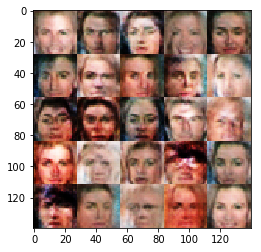

Epoch 1/1.. Steps 2710.. Discriminator Loss: 1.0377.. Generator Loss: 1.3150
Epoch 1/1.. Steps 2720.. Discriminator Loss: 1.0919.. Generator Loss: 0.8967
Epoch 1/1.. Steps 2730.. Discriminator Loss: 1.3169.. Generator Loss: 0.6737
Epoch 1/1.. Steps 2740.. Discriminator Loss: 0.9878.. Generator Loss: 1.0940
Epoch 1/1.. Steps 2750.. Discriminator Loss: 1.0355.. Generator Loss: 1.0829
Epoch 1/1.. Steps 2760.. Discriminator Loss: 1.1296.. Generator Loss: 1.7601
Epoch 1/1.. Steps 2770.. Discriminator Loss: 1.1291.. Generator Loss: 0.7872
Epoch 1/1.. Steps 2780.. Discriminator Loss: 1.4730.. Generator Loss: 0.4660
Epoch 1/1.. Steps 2790.. Discriminator Loss: 1.1928.. Generator Loss: 0.7679
Epoch 1/1.. Steps 2800.. Discriminator Loss: 1.2729.. Generator Loss: 0.6436


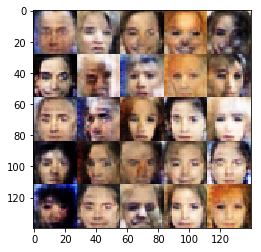

Epoch 1/1.. Steps 2810.. Discriminator Loss: 1.1803.. Generator Loss: 1.6496
Epoch 1/1.. Steps 2820.. Discriminator Loss: 1.0862.. Generator Loss: 0.8923
Epoch 1/1.. Steps 2830.. Discriminator Loss: 1.1210.. Generator Loss: 0.9986
Epoch 1/1.. Steps 2840.. Discriminator Loss: 1.3721.. Generator Loss: 0.5957
Epoch 1/1.. Steps 2850.. Discriminator Loss: 1.1940.. Generator Loss: 0.7058
Epoch 1/1.. Steps 2860.. Discriminator Loss: 1.0931.. Generator Loss: 0.8293
Epoch 1/1.. Steps 2870.. Discriminator Loss: 1.1375.. Generator Loss: 0.9627
Epoch 1/1.. Steps 2880.. Discriminator Loss: 1.1070.. Generator Loss: 0.8809
Epoch 1/1.. Steps 2890.. Discriminator Loss: 0.8785.. Generator Loss: 1.8966
Epoch 1/1.. Steps 2900.. Discriminator Loss: 1.1938.. Generator Loss: 0.7403


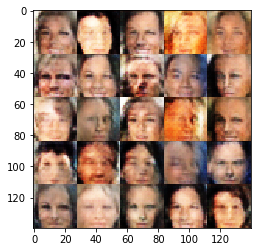

Epoch 1/1.. Steps 2910.. Discriminator Loss: 1.0665.. Generator Loss: 1.1445
Epoch 1/1.. Steps 2920.. Discriminator Loss: 1.7332.. Generator Loss: 0.3404
Epoch 1/1.. Steps 2930.. Discriminator Loss: 1.1248.. Generator Loss: 0.8328
Epoch 1/1.. Steps 2940.. Discriminator Loss: 1.0861.. Generator Loss: 1.1230
Epoch 1/1.. Steps 2950.. Discriminator Loss: 1.1836.. Generator Loss: 0.7084
Epoch 1/1.. Steps 2960.. Discriminator Loss: 0.9616.. Generator Loss: 1.5875
Epoch 1/1.. Steps 2970.. Discriminator Loss: 0.9100.. Generator Loss: 1.2317
Epoch 1/1.. Steps 2980.. Discriminator Loss: 1.1525.. Generator Loss: 0.8699
Epoch 1/1.. Steps 2990.. Discriminator Loss: 0.9751.. Generator Loss: 1.0313
Epoch 1/1.. Steps 3000.. Discriminator Loss: 0.9132.. Generator Loss: 1.3194


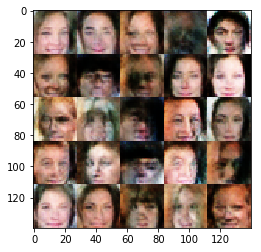

Epoch 1/1.. Steps 3010.. Discriminator Loss: 1.3100.. Generator Loss: 0.6191
Epoch 1/1.. Steps 3020.. Discriminator Loss: 1.4354.. Generator Loss: 0.4866
Epoch 1/1.. Steps 3030.. Discriminator Loss: 1.1739.. Generator Loss: 0.7105
Epoch 1/1.. Steps 3040.. Discriminator Loss: 1.3919.. Generator Loss: 1.9300
Epoch 1/1.. Steps 3050.. Discriminator Loss: 0.8862.. Generator Loss: 1.3294
Epoch 1/1.. Steps 3060.. Discriminator Loss: 1.1475.. Generator Loss: 1.6568
Epoch 1/1.. Steps 3070.. Discriminator Loss: 0.9297.. Generator Loss: 1.2758
Epoch 1/1.. Steps 3080.. Discriminator Loss: 1.0102.. Generator Loss: 1.0753
Epoch 1/1.. Steps 3090.. Discriminator Loss: 1.2812.. Generator Loss: 0.6009
Epoch 1/1.. Steps 3100.. Discriminator Loss: 1.2004.. Generator Loss: 0.7532


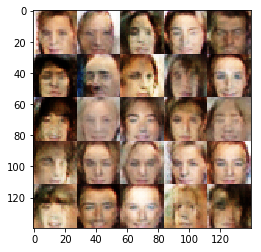

Epoch 1/1.. Steps 3110.. Discriminator Loss: 1.0290.. Generator Loss: 1.0016
Epoch 1/1.. Steps 3120.. Discriminator Loss: 1.1725.. Generator Loss: 0.8387
Epoch 1/1.. Steps 3130.. Discriminator Loss: 0.8882.. Generator Loss: 1.4171
Epoch 1/1.. Steps 3140.. Discriminator Loss: 0.9909.. Generator Loss: 1.0398
Epoch 1/1.. Steps 3150.. Discriminator Loss: 1.0013.. Generator Loss: 1.0730
Epoch 1/1.. Steps 3160.. Discriminator Loss: 1.3744.. Generator Loss: 0.5825
Epoch 1/1.. Steps 3170.. Discriminator Loss: 0.9281.. Generator Loss: 1.2511
Epoch 1/1.. Steps 3180.. Discriminator Loss: 1.1639.. Generator Loss: 0.8031
Epoch 1/1.. Steps 3190.. Discriminator Loss: 1.2547.. Generator Loss: 0.6552
Epoch 1/1.. Steps 3200.. Discriminator Loss: 1.1228.. Generator Loss: 0.7388


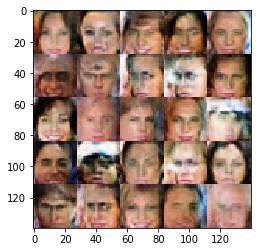

Epoch 1/1.. Steps 3210.. Discriminator Loss: 0.8684.. Generator Loss: 1.4737
Epoch 1/1.. Steps 3220.. Discriminator Loss: 1.1421.. Generator Loss: 1.5637
Epoch 1/1.. Steps 3230.. Discriminator Loss: 1.1798.. Generator Loss: 0.7100
Epoch 1/1.. Steps 3240.. Discriminator Loss: 0.9747.. Generator Loss: 1.5815
Epoch 1/1.. Steps 3250.. Discriminator Loss: 0.9965.. Generator Loss: 1.0309
Epoch 1/1.. Steps 3260.. Discriminator Loss: 1.1089.. Generator Loss: 1.6360
Epoch 1/1.. Steps 3270.. Discriminator Loss: 1.1599.. Generator Loss: 0.7785
Epoch 1/1.. Steps 3280.. Discriminator Loss: 1.2732.. Generator Loss: 0.6461
Epoch 1/1.. Steps 3290.. Discriminator Loss: 1.3750.. Generator Loss: 0.5747
Epoch 1/1.. Steps 3300.. Discriminator Loss: 1.1708.. Generator Loss: 2.1163


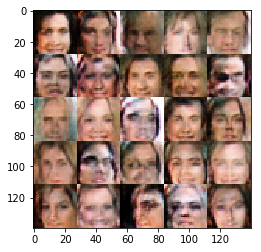

Epoch 1/1.. Steps 3310.. Discriminator Loss: 1.1249.. Generator Loss: 0.8134
Epoch 1/1.. Steps 3320.. Discriminator Loss: 1.1292.. Generator Loss: 0.9285
Epoch 1/1.. Steps 3330.. Discriminator Loss: 1.2264.. Generator Loss: 0.7847
Epoch 1/1.. Steps 3340.. Discriminator Loss: 0.9774.. Generator Loss: 1.4548
Epoch 1/1.. Steps 3350.. Discriminator Loss: 1.1221.. Generator Loss: 0.8674
Epoch 1/1.. Steps 3360.. Discriminator Loss: 1.0583.. Generator Loss: 1.8323
Epoch 1/1.. Steps 3370.. Discriminator Loss: 1.0656.. Generator Loss: 0.9624
Epoch 1/1.. Steps 3380.. Discriminator Loss: 0.9746.. Generator Loss: 1.2493
Epoch 1/1.. Steps 3390.. Discriminator Loss: 1.1027.. Generator Loss: 2.0584
Epoch 1/1.. Steps 3400.. Discriminator Loss: 1.3260.. Generator Loss: 0.6567


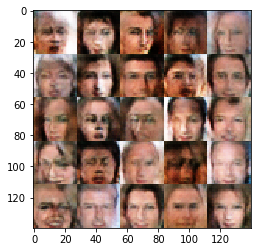

Epoch 1/1.. Steps 3410.. Discriminator Loss: 1.4073.. Generator Loss: 0.5301
Epoch 1/1.. Steps 3420.. Discriminator Loss: 1.2020.. Generator Loss: 0.7216
Epoch 1/1.. Steps 3430.. Discriminator Loss: 1.3553.. Generator Loss: 0.5831
Epoch 1/1.. Steps 3440.. Discriminator Loss: 1.0767.. Generator Loss: 0.8253
Epoch 1/1.. Steps 3450.. Discriminator Loss: 1.3133.. Generator Loss: 0.6959
Epoch 1/1.. Steps 3460.. Discriminator Loss: 1.3258.. Generator Loss: 0.6447
Epoch 1/1.. Steps 3470.. Discriminator Loss: 0.9770.. Generator Loss: 1.0063
Epoch 1/1.. Steps 3480.. Discriminator Loss: 1.0774.. Generator Loss: 0.9303
Epoch 1/1.. Steps 3490.. Discriminator Loss: 1.0994.. Generator Loss: 1.0268
Epoch 1/1.. Steps 3500.. Discriminator Loss: 0.8790.. Generator Loss: 1.1019


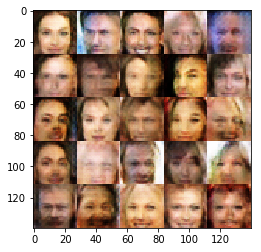

Epoch 1/1.. Steps 3510.. Discriminator Loss: 1.1032.. Generator Loss: 1.0085
Epoch 1/1.. Steps 3520.. Discriminator Loss: 1.1243.. Generator Loss: 0.8629
Epoch 1/1.. Steps 3530.. Discriminator Loss: 1.1926.. Generator Loss: 1.3222
Epoch 1/1.. Steps 3540.. Discriminator Loss: 1.1178.. Generator Loss: 0.8761
Epoch 1/1.. Steps 3550.. Discriminator Loss: 1.2066.. Generator Loss: 0.7623
Epoch 1/1.. Steps 3560.. Discriminator Loss: 0.9794.. Generator Loss: 1.4710
Epoch 1/1.. Steps 3570.. Discriminator Loss: 0.9924.. Generator Loss: 1.1223
Epoch 1/1.. Steps 3580.. Discriminator Loss: 1.0894.. Generator Loss: 1.2379
Epoch 1/1.. Steps 3590.. Discriminator Loss: 1.0814.. Generator Loss: 1.4064
Epoch 1/1.. Steps 3600.. Discriminator Loss: 0.9524.. Generator Loss: 1.1249


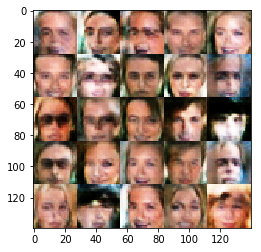

Epoch 1/1.. Steps 3610.. Discriminator Loss: 1.2197.. Generator Loss: 0.6943
Epoch 1/1.. Steps 3620.. Discriminator Loss: 1.2541.. Generator Loss: 0.7140
Epoch 1/1.. Steps 3630.. Discriminator Loss: 1.1463.. Generator Loss: 0.7265
Epoch 1/1.. Steps 3640.. Discriminator Loss: 1.1935.. Generator Loss: 0.9448
Epoch 1/1.. Steps 3650.. Discriminator Loss: 1.0117.. Generator Loss: 1.2951
Epoch 1/1.. Steps 3660.. Discriminator Loss: 1.1445.. Generator Loss: 0.7521
Epoch 1/1.. Steps 3670.. Discriminator Loss: 1.1237.. Generator Loss: 1.0486
Epoch 1/1.. Steps 3680.. Discriminator Loss: 1.5205.. Generator Loss: 2.5510
Epoch 1/1.. Steps 3690.. Discriminator Loss: 0.8968.. Generator Loss: 1.3178
Epoch 1/1.. Steps 3700.. Discriminator Loss: 0.9650.. Generator Loss: 1.6540


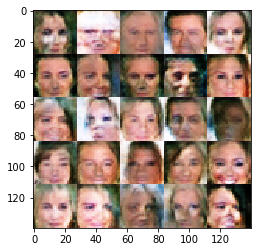

Epoch 1/1.. Steps 3710.. Discriminator Loss: 1.0872.. Generator Loss: 1.1036
Epoch 1/1.. Steps 3720.. Discriminator Loss: 1.1722.. Generator Loss: 1.3330
Epoch 1/1.. Steps 3730.. Discriminator Loss: 1.1065.. Generator Loss: 1.3341
Epoch 1/1.. Steps 3740.. Discriminator Loss: 1.2580.. Generator Loss: 1.2941
Epoch 1/1.. Steps 3750.. Discriminator Loss: 1.2374.. Generator Loss: 1.2967
Epoch 1/1.. Steps 3760.. Discriminator Loss: 0.8331.. Generator Loss: 1.3014
Epoch 1/1.. Steps 3770.. Discriminator Loss: 1.3229.. Generator Loss: 0.5612
Epoch 1/1.. Steps 3780.. Discriminator Loss: 0.9462.. Generator Loss: 1.3605
Epoch 1/1.. Steps 3790.. Discriminator Loss: 1.5188.. Generator Loss: 0.4265
Epoch 1/1.. Steps 3800.. Discriminator Loss: 0.9756.. Generator Loss: 1.1026


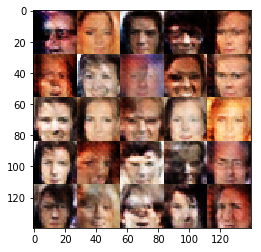

Epoch 1/1.. Steps 3810.. Discriminator Loss: 1.5233.. Generator Loss: 1.1251
Epoch 1/1.. Steps 3820.. Discriminator Loss: 1.0793.. Generator Loss: 1.1052
Epoch 1/1.. Steps 3830.. Discriminator Loss: 1.0380.. Generator Loss: 1.0365
Epoch 1/1.. Steps 3840.. Discriminator Loss: 1.2029.. Generator Loss: 1.1257
Epoch 1/1.. Steps 3850.. Discriminator Loss: 1.1088.. Generator Loss: 1.1472
Epoch 1/1.. Steps 3860.. Discriminator Loss: 1.1029.. Generator Loss: 0.8402
Epoch 1/1.. Steps 3870.. Discriminator Loss: 1.1368.. Generator Loss: 0.7578
Epoch 1/1.. Steps 3880.. Discriminator Loss: 1.3774.. Generator Loss: 0.5804
Epoch 1/1.. Steps 3890.. Discriminator Loss: 1.0401.. Generator Loss: 0.8268
Epoch 1/1.. Steps 3900.. Discriminator Loss: 1.2033.. Generator Loss: 0.8774


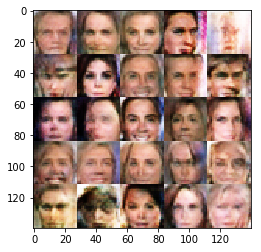

Epoch 1/1.. Steps 3910.. Discriminator Loss: 1.2279.. Generator Loss: 1.5678
Epoch 1/1.. Steps 3920.. Discriminator Loss: 1.0348.. Generator Loss: 1.5085
Epoch 1/1.. Steps 3930.. Discriminator Loss: 0.9947.. Generator Loss: 1.3445
Epoch 1/1.. Steps 3940.. Discriminator Loss: 0.9567.. Generator Loss: 1.0206
Epoch 1/1.. Steps 3950.. Discriminator Loss: 1.1231.. Generator Loss: 1.1276
Epoch 1/1.. Steps 3960.. Discriminator Loss: 1.2625.. Generator Loss: 0.6364
Epoch 1/1.. Steps 3970.. Discriminator Loss: 1.0176.. Generator Loss: 1.0859
Epoch 1/1.. Steps 3980.. Discriminator Loss: 1.0920.. Generator Loss: 0.9276
Epoch 1/1.. Steps 3990.. Discriminator Loss: 1.2486.. Generator Loss: 0.7568
Epoch 1/1.. Steps 4000.. Discriminator Loss: 0.8941.. Generator Loss: 1.2922


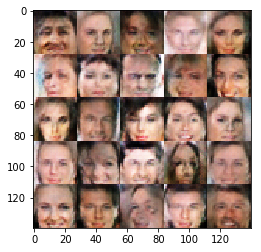

Epoch 1/1.. Steps 4010.. Discriminator Loss: 1.0695.. Generator Loss: 1.0605
Epoch 1/1.. Steps 4020.. Discriminator Loss: 1.4924.. Generator Loss: 0.5096
Epoch 1/1.. Steps 4030.. Discriminator Loss: 1.1359.. Generator Loss: 0.9501
Epoch 1/1.. Steps 4040.. Discriminator Loss: 1.1691.. Generator Loss: 1.0601
Epoch 1/1.. Steps 4050.. Discriminator Loss: 1.2373.. Generator Loss: 0.6958
Epoch 1/1.. Steps 4060.. Discriminator Loss: 1.2551.. Generator Loss: 0.6361
Epoch 1/1.. Steps 4070.. Discriminator Loss: 1.8772.. Generator Loss: 0.2903
Epoch 1/1.. Steps 4080.. Discriminator Loss: 1.0399.. Generator Loss: 1.3773
Epoch 1/1.. Steps 4090.. Discriminator Loss: 1.0830.. Generator Loss: 1.5547
Epoch 1/1.. Steps 4100.. Discriminator Loss: 1.1597.. Generator Loss: 0.7666


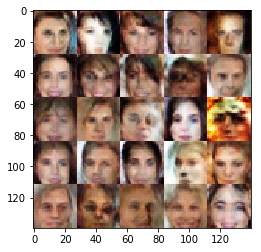

Epoch 1/1.. Steps 4110.. Discriminator Loss: 1.1460.. Generator Loss: 0.8031
Epoch 1/1.. Steps 4120.. Discriminator Loss: 1.1766.. Generator Loss: 0.7928
Epoch 1/1.. Steps 4130.. Discriminator Loss: 1.1823.. Generator Loss: 0.7642
Epoch 1/1.. Steps 4140.. Discriminator Loss: 1.1637.. Generator Loss: 0.6713
Epoch 1/1.. Steps 4150.. Discriminator Loss: 1.2110.. Generator Loss: 0.7817
Epoch 1/1.. Steps 4160.. Discriminator Loss: 1.2255.. Generator Loss: 1.1799
Epoch 1/1.. Steps 4170.. Discriminator Loss: 1.1451.. Generator Loss: 0.8335
Epoch 1/1.. Steps 4180.. Discriminator Loss: 1.2077.. Generator Loss: 1.4920
Epoch 1/1.. Steps 4190.. Discriminator Loss: 1.1603.. Generator Loss: 1.5801
Epoch 1/1.. Steps 4200.. Discriminator Loss: 1.0156.. Generator Loss: 0.9758


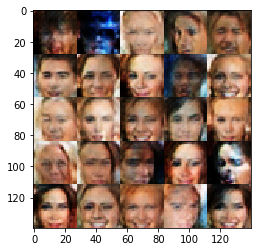

Epoch 1/1.. Steps 4210.. Discriminator Loss: 1.3282.. Generator Loss: 0.5751
Epoch 1/1.. Steps 4220.. Discriminator Loss: 1.0720.. Generator Loss: 0.9731
Epoch 1/1.. Steps 4230.. Discriminator Loss: 1.0055.. Generator Loss: 1.3986
Epoch 1/1.. Steps 4240.. Discriminator Loss: 1.0532.. Generator Loss: 1.0526
Epoch 1/1.. Steps 4250.. Discriminator Loss: 0.9214.. Generator Loss: 1.1400
Epoch 1/1.. Steps 4260.. Discriminator Loss: 1.0882.. Generator Loss: 1.2467
Epoch 1/1.. Steps 4270.. Discriminator Loss: 1.2799.. Generator Loss: 0.6630
Epoch 1/1.. Steps 4280.. Discriminator Loss: 1.3113.. Generator Loss: 0.6985
Epoch 1/1.. Steps 4290.. Discriminator Loss: 1.1495.. Generator Loss: 0.8102
Epoch 1/1.. Steps 4300.. Discriminator Loss: 1.2230.. Generator Loss: 1.2882


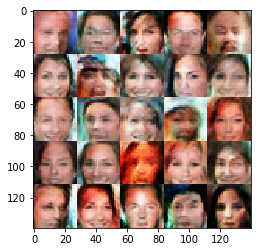

Epoch 1/1.. Steps 4310.. Discriminator Loss: 1.0936.. Generator Loss: 0.8313
Epoch 1/1.. Steps 4320.. Discriminator Loss: 1.4698.. Generator Loss: 0.5348
Epoch 1/1.. Steps 4330.. Discriminator Loss: 1.0701.. Generator Loss: 0.8947
Epoch 1/1.. Steps 4340.. Discriminator Loss: 1.1591.. Generator Loss: 0.9124
Epoch 1/1.. Steps 4350.. Discriminator Loss: 1.0989.. Generator Loss: 1.5567
Epoch 1/1.. Steps 4360.. Discriminator Loss: 1.2753.. Generator Loss: 0.6205
Epoch 1/1.. Steps 4370.. Discriminator Loss: 1.1743.. Generator Loss: 0.9047
Epoch 1/1.. Steps 4380.. Discriminator Loss: 1.0845.. Generator Loss: 1.6623
Epoch 1/1.. Steps 4390.. Discriminator Loss: 1.1476.. Generator Loss: 0.7921
Epoch 1/1.. Steps 4400.. Discriminator Loss: 1.1407.. Generator Loss: 0.8359


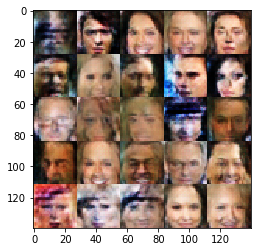

Epoch 1/1.. Steps 4410.. Discriminator Loss: 1.6468.. Generator Loss: 0.4335
Epoch 1/1.. Steps 4420.. Discriminator Loss: 1.0575.. Generator Loss: 0.8870
Epoch 1/1.. Steps 4430.. Discriminator Loss: 1.0359.. Generator Loss: 1.5684
Epoch 1/1.. Steps 4440.. Discriminator Loss: 1.0011.. Generator Loss: 0.9693
Epoch 1/1.. Steps 4450.. Discriminator Loss: 1.3858.. Generator Loss: 0.5618
Epoch 1/1.. Steps 4460.. Discriminator Loss: 1.0275.. Generator Loss: 1.2528
Epoch 1/1.. Steps 4470.. Discriminator Loss: 1.1893.. Generator Loss: 1.5865
Epoch 1/1.. Steps 4480.. Discriminator Loss: 1.4171.. Generator Loss: 0.5355
Epoch 1/1.. Steps 4490.. Discriminator Loss: 1.0474.. Generator Loss: 1.0469
Epoch 1/1.. Steps 4500.. Discriminator Loss: 1.0786.. Generator Loss: 0.9004


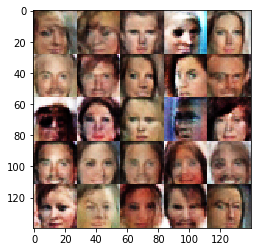

Epoch 1/1.. Steps 4510.. Discriminator Loss: 1.3518.. Generator Loss: 0.5911
Epoch 1/1.. Steps 4520.. Discriminator Loss: 1.3015.. Generator Loss: 0.7835
Epoch 1/1.. Steps 4530.. Discriminator Loss: 1.0866.. Generator Loss: 1.2411
Epoch 1/1.. Steps 4540.. Discriminator Loss: 1.1748.. Generator Loss: 1.2513
Epoch 1/1.. Steps 4550.. Discriminator Loss: 0.9681.. Generator Loss: 1.0626
Epoch 1/1.. Steps 4560.. Discriminator Loss: 1.2760.. Generator Loss: 0.6602
Epoch 1/1.. Steps 4570.. Discriminator Loss: 1.1756.. Generator Loss: 0.7390
Epoch 1/1.. Steps 4580.. Discriminator Loss: 1.2954.. Generator Loss: 0.6092
Epoch 1/1.. Steps 4590.. Discriminator Loss: 1.1753.. Generator Loss: 0.9503
Epoch 1/1.. Steps 4600.. Discriminator Loss: 1.1644.. Generator Loss: 1.5831


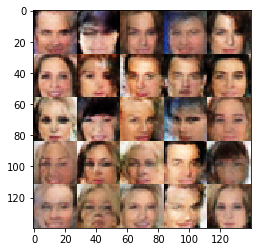

Epoch 1/1.. Steps 4610.. Discriminator Loss: 1.0709.. Generator Loss: 1.1081
Epoch 1/1.. Steps 4620.. Discriminator Loss: 0.9571.. Generator Loss: 1.1232
Epoch 1/1.. Steps 4630.. Discriminator Loss: 1.1185.. Generator Loss: 1.2600
Epoch 1/1.. Steps 4640.. Discriminator Loss: 1.2419.. Generator Loss: 0.7421
Epoch 1/1.. Steps 4650.. Discriminator Loss: 1.1711.. Generator Loss: 0.9037
Epoch 1/1.. Steps 4660.. Discriminator Loss: 1.1939.. Generator Loss: 0.8742
Epoch 1/1.. Steps 4670.. Discriminator Loss: 1.1462.. Generator Loss: 1.2018
Epoch 1/1.. Steps 4680.. Discriminator Loss: 1.2724.. Generator Loss: 1.3399
Epoch 1/1.. Steps 4690.. Discriminator Loss: 1.2800.. Generator Loss: 0.6260
Epoch 1/1.. Steps 4700.. Discriminator Loss: 1.2279.. Generator Loss: 0.6727


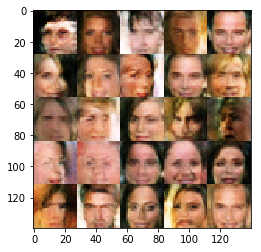

Epoch 1/1.. Steps 4710.. Discriminator Loss: 1.0199.. Generator Loss: 1.1794
Epoch 1/1.. Steps 4720.. Discriminator Loss: 0.9869.. Generator Loss: 1.0954
Epoch 1/1.. Steps 4730.. Discriminator Loss: 1.1582.. Generator Loss: 0.8148
Epoch 1/1.. Steps 4740.. Discriminator Loss: 1.2776.. Generator Loss: 1.6574
Epoch 1/1.. Steps 4750.. Discriminator Loss: 1.0348.. Generator Loss: 0.8950
Epoch 1/1.. Steps 4760.. Discriminator Loss: 1.1207.. Generator Loss: 0.7507
Epoch 1/1.. Steps 4770.. Discriminator Loss: 1.0676.. Generator Loss: 1.1505
Epoch 1/1.. Steps 4780.. Discriminator Loss: 1.2977.. Generator Loss: 0.6558
Epoch 1/1.. Steps 4790.. Discriminator Loss: 1.0110.. Generator Loss: 1.1122
Epoch 1/1.. Steps 4800.. Discriminator Loss: 1.1223.. Generator Loss: 0.8286


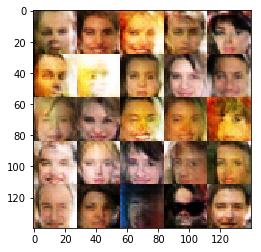

Epoch 1/1.. Steps 4810.. Discriminator Loss: 1.2814.. Generator Loss: 1.2346
Epoch 1/1.. Steps 4820.. Discriminator Loss: 1.0519.. Generator Loss: 1.0660
Epoch 1/1.. Steps 4830.. Discriminator Loss: 1.2019.. Generator Loss: 0.7876
Epoch 1/1.. Steps 4840.. Discriminator Loss: 1.3400.. Generator Loss: 0.5327
Epoch 1/1.. Steps 4850.. Discriminator Loss: 1.0645.. Generator Loss: 0.9000
Epoch 1/1.. Steps 4860.. Discriminator Loss: 1.5355.. Generator Loss: 0.4401
Epoch 1/1.. Steps 4870.. Discriminator Loss: 1.1058.. Generator Loss: 0.7663
Epoch 1/1.. Steps 4880.. Discriminator Loss: 1.1818.. Generator Loss: 1.0341
Epoch 1/1.. Steps 4890.. Discriminator Loss: 1.0047.. Generator Loss: 0.9225
Epoch 1/1.. Steps 4900.. Discriminator Loss: 1.2282.. Generator Loss: 0.6340


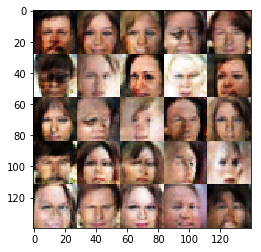

Epoch 1/1.. Steps 4910.. Discriminator Loss: 1.1598.. Generator Loss: 0.8298
Epoch 1/1.. Steps 4920.. Discriminator Loss: 1.4338.. Generator Loss: 0.5358
Epoch 1/1.. Steps 4930.. Discriminator Loss: 1.2140.. Generator Loss: 0.8625
Epoch 1/1.. Steps 4940.. Discriminator Loss: 1.0595.. Generator Loss: 1.0602
Epoch 1/1.. Steps 4950.. Discriminator Loss: 1.0917.. Generator Loss: 0.9028
Epoch 1/1.. Steps 4960.. Discriminator Loss: 1.2253.. Generator Loss: 0.6847
Epoch 1/1.. Steps 4970.. Discriminator Loss: 1.0748.. Generator Loss: 1.3482
Epoch 1/1.. Steps 4980.. Discriminator Loss: 1.0222.. Generator Loss: 0.9320
Epoch 1/1.. Steps 4990.. Discriminator Loss: 1.2003.. Generator Loss: 1.2731
Epoch 1/1.. Steps 5000.. Discriminator Loss: 1.2312.. Generator Loss: 1.4991


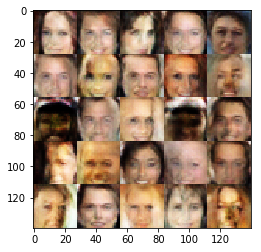

Epoch 1/1.. Steps 5010.. Discriminator Loss: 1.2180.. Generator Loss: 0.9177
Epoch 1/1.. Steps 5020.. Discriminator Loss: 1.4445.. Generator Loss: 0.4930
Epoch 1/1.. Steps 5030.. Discriminator Loss: 1.1649.. Generator Loss: 0.9265
Epoch 1/1.. Steps 5040.. Discriminator Loss: 1.0301.. Generator Loss: 1.1214
Epoch 1/1.. Steps 5050.. Discriminator Loss: 1.1822.. Generator Loss: 0.7207
Epoch 1/1.. Steps 5060.. Discriminator Loss: 1.1421.. Generator Loss: 0.8937
Epoch 1/1.. Steps 5070.. Discriminator Loss: 1.1109.. Generator Loss: 1.2990
Epoch 1/1.. Steps 5080.. Discriminator Loss: 1.1856.. Generator Loss: 0.6645
Epoch 1/1.. Steps 5090.. Discriminator Loss: 1.2934.. Generator Loss: 0.6150
Epoch 1/1.. Steps 5100.. Discriminator Loss: 1.1812.. Generator Loss: 0.8409


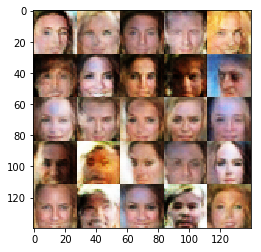

Epoch 1/1.. Steps 5110.. Discriminator Loss: 1.5128.. Generator Loss: 0.4427
Epoch 1/1.. Steps 5120.. Discriminator Loss: 1.1648.. Generator Loss: 0.8390
Epoch 1/1.. Steps 5130.. Discriminator Loss: 1.2351.. Generator Loss: 0.6966
Epoch 1/1.. Steps 5140.. Discriminator Loss: 1.2049.. Generator Loss: 0.9208
Epoch 1/1.. Steps 5150.. Discriminator Loss: 1.2677.. Generator Loss: 0.7035
Epoch 1/1.. Steps 5160.. Discriminator Loss: 1.2665.. Generator Loss: 0.6423
Epoch 1/1.. Steps 5170.. Discriminator Loss: 1.3030.. Generator Loss: 0.6560
Epoch 1/1.. Steps 5180.. Discriminator Loss: 1.0025.. Generator Loss: 1.0131
Epoch 1/1.. Steps 5190.. Discriminator Loss: 1.2615.. Generator Loss: 0.6153
Epoch 1/1.. Steps 5200.. Discriminator Loss: 1.2620.. Generator Loss: 0.8545


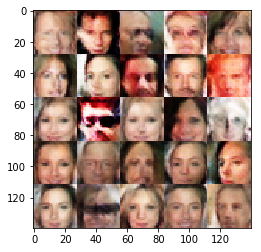

Epoch 1/1.. Steps 5210.. Discriminator Loss: 1.1072.. Generator Loss: 1.0549
Epoch 1/1.. Steps 5220.. Discriminator Loss: 1.1035.. Generator Loss: 0.9183
Epoch 1/1.. Steps 5230.. Discriminator Loss: 1.5005.. Generator Loss: 0.4740
Epoch 1/1.. Steps 5240.. Discriminator Loss: 1.1324.. Generator Loss: 1.6786
Epoch 1/1.. Steps 5250.. Discriminator Loss: 1.4095.. Generator Loss: 0.5451
Epoch 1/1.. Steps 5260.. Discriminator Loss: 1.3241.. Generator Loss: 0.5275
Epoch 1/1.. Steps 5270.. Discriminator Loss: 1.1705.. Generator Loss: 0.7318
Epoch 1/1.. Steps 5280.. Discriminator Loss: 1.1104.. Generator Loss: 0.8257
Epoch 1/1.. Steps 5290.. Discriminator Loss: 1.3798.. Generator Loss: 0.6651
Epoch 1/1.. Steps 5300.. Discriminator Loss: 1.1388.. Generator Loss: 0.7249


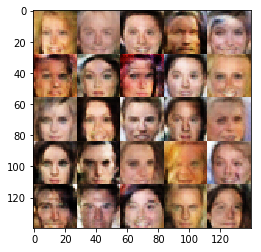

Epoch 1/1.. Steps 5310.. Discriminator Loss: 1.3358.. Generator Loss: 0.7796
Epoch 1/1.. Steps 5320.. Discriminator Loss: 1.2247.. Generator Loss: 0.8365
Epoch 1/1.. Steps 5330.. Discriminator Loss: 1.1458.. Generator Loss: 1.0896
Epoch 1/1.. Steps 5340.. Discriminator Loss: 1.2501.. Generator Loss: 0.6320
Epoch 1/1.. Steps 5350.. Discriminator Loss: 1.0119.. Generator Loss: 1.1604
Epoch 1/1.. Steps 5360.. Discriminator Loss: 1.0772.. Generator Loss: 1.1937
Epoch 1/1.. Steps 5370.. Discriminator Loss: 1.1136.. Generator Loss: 0.8488
Epoch 1/1.. Steps 5380.. Discriminator Loss: 1.0913.. Generator Loss: 0.8904
Epoch 1/1.. Steps 5390.. Discriminator Loss: 1.2185.. Generator Loss: 0.7938
Epoch 1/1.. Steps 5400.. Discriminator Loss: 1.1364.. Generator Loss: 0.9043


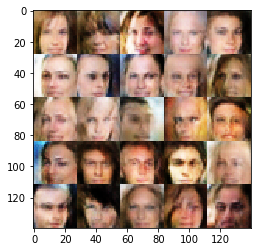

Epoch 1/1.. Steps 5410.. Discriminator Loss: 1.4166.. Generator Loss: 0.5346
Epoch 1/1.. Steps 5420.. Discriminator Loss: 1.0014.. Generator Loss: 1.0848
Epoch 1/1.. Steps 5430.. Discriminator Loss: 1.2039.. Generator Loss: 0.8827
Epoch 1/1.. Steps 5440.. Discriminator Loss: 1.0776.. Generator Loss: 1.2364
Epoch 1/1.. Steps 5450.. Discriminator Loss: 1.0504.. Generator Loss: 1.2149
Epoch 1/1.. Steps 5460.. Discriminator Loss: 1.5024.. Generator Loss: 0.4571
Epoch 1/1.. Steps 5470.. Discriminator Loss: 1.1681.. Generator Loss: 0.8074
Epoch 1/1.. Steps 5480.. Discriminator Loss: 1.4515.. Generator Loss: 0.4822
Epoch 1/1.. Steps 5490.. Discriminator Loss: 1.2473.. Generator Loss: 0.7610
Epoch 1/1.. Steps 5500.. Discriminator Loss: 1.1486.. Generator Loss: 0.7355


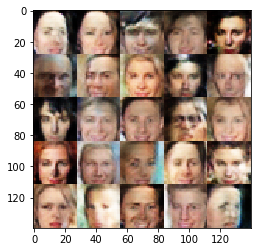

Epoch 1/1.. Steps 5510.. Discriminator Loss: 1.0947.. Generator Loss: 0.9286
Epoch 1/1.. Steps 5520.. Discriminator Loss: 1.3010.. Generator Loss: 0.6654
Epoch 1/1.. Steps 5530.. Discriminator Loss: 1.5414.. Generator Loss: 0.4513
Epoch 1/1.. Steps 5540.. Discriminator Loss: 1.0740.. Generator Loss: 0.9198
Epoch 1/1.. Steps 5550.. Discriminator Loss: 1.3859.. Generator Loss: 0.5769
Epoch 1/1.. Steps 5560.. Discriminator Loss: 1.0314.. Generator Loss: 1.0707
Epoch 1/1.. Steps 5570.. Discriminator Loss: 0.9452.. Generator Loss: 1.2609
Epoch 1/1.. Steps 5580.. Discriminator Loss: 1.2148.. Generator Loss: 0.6288
Epoch 1/1.. Steps 5590.. Discriminator Loss: 1.1922.. Generator Loss: 1.5327
Epoch 1/1.. Steps 5600.. Discriminator Loss: 1.2429.. Generator Loss: 0.6522


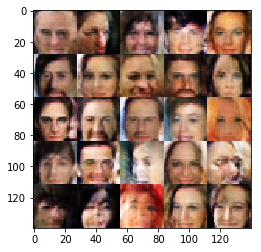

Epoch 1/1.. Steps 5610.. Discriminator Loss: 1.1850.. Generator Loss: 0.8259
Epoch 1/1.. Steps 5620.. Discriminator Loss: 1.2668.. Generator Loss: 0.6398
Epoch 1/1.. Steps 5630.. Discriminator Loss: 1.2057.. Generator Loss: 0.6521
Epoch 1/1.. Steps 5640.. Discriminator Loss: 1.2519.. Generator Loss: 0.7644
Epoch 1/1.. Steps 5650.. Discriminator Loss: 1.0395.. Generator Loss: 1.3132
Epoch 1/1.. Steps 5660.. Discriminator Loss: 1.3282.. Generator Loss: 0.5937
Epoch 1/1.. Steps 5670.. Discriminator Loss: 1.0503.. Generator Loss: 1.5243
Epoch 1/1.. Steps 5680.. Discriminator Loss: 1.2316.. Generator Loss: 0.6923
Epoch 1/1.. Steps 5690.. Discriminator Loss: 1.4693.. Generator Loss: 0.5651
Epoch 1/1.. Steps 5700.. Discriminator Loss: 1.0453.. Generator Loss: 1.0751


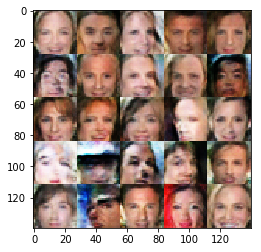

Epoch 1/1.. Steps 5710.. Discriminator Loss: 1.1777.. Generator Loss: 0.7934
Epoch 1/1.. Steps 5720.. Discriminator Loss: 1.1264.. Generator Loss: 1.2444
Epoch 1/1.. Steps 5730.. Discriminator Loss: 1.8499.. Generator Loss: 0.3151
Epoch 1/1.. Steps 5740.. Discriminator Loss: 1.0779.. Generator Loss: 1.0608
Epoch 1/1.. Steps 5750.. Discriminator Loss: 1.1500.. Generator Loss: 0.9671
Epoch 1/1.. Steps 5760.. Discriminator Loss: 1.1647.. Generator Loss: 0.8173
Epoch 1/1.. Steps 5770.. Discriminator Loss: 1.5005.. Generator Loss: 0.4861
Epoch 1/1.. Steps 5780.. Discriminator Loss: 1.0566.. Generator Loss: 1.2539
Epoch 1/1.. Steps 5790.. Discriminator Loss: 1.1853.. Generator Loss: 0.7391
Epoch 1/1.. Steps 5800.. Discriminator Loss: 1.3127.. Generator Loss: 0.6060


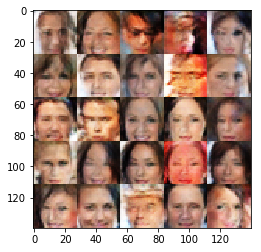

Epoch 1/1.. Steps 5810.. Discriminator Loss: 1.1444.. Generator Loss: 1.0804
Epoch 1/1.. Steps 5820.. Discriminator Loss: 1.3243.. Generator Loss: 0.5503
Epoch 1/1.. Steps 5830.. Discriminator Loss: 1.5004.. Generator Loss: 0.4594
Epoch 1/1.. Steps 5840.. Discriminator Loss: 1.0239.. Generator Loss: 1.1465
Epoch 1/1.. Steps 5850.. Discriminator Loss: 1.2695.. Generator Loss: 0.7437
Epoch 1/1.. Steps 5860.. Discriminator Loss: 1.2109.. Generator Loss: 0.7828
Epoch 1/1.. Steps 5870.. Discriminator Loss: 1.2540.. Generator Loss: 0.6952
Epoch 1/1.. Steps 5880.. Discriminator Loss: 1.2433.. Generator Loss: 0.7144
Epoch 1/1.. Steps 5890.. Discriminator Loss: 1.1315.. Generator Loss: 0.7133
Epoch 1/1.. Steps 5900.. Discriminator Loss: 1.0539.. Generator Loss: 1.2614


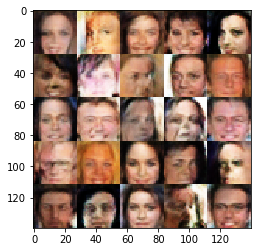

Epoch 1/1.. Steps 5910.. Discriminator Loss: 0.9775.. Generator Loss: 1.1264
Epoch 1/1.. Steps 5920.. Discriminator Loss: 1.0420.. Generator Loss: 1.0957
Epoch 1/1.. Steps 5930.. Discriminator Loss: 1.2757.. Generator Loss: 0.8396
Epoch 1/1.. Steps 5940.. Discriminator Loss: 0.9725.. Generator Loss: 0.9828
Epoch 1/1.. Steps 5950.. Discriminator Loss: 1.1798.. Generator Loss: 0.8867
Epoch 1/1.. Steps 5960.. Discriminator Loss: 1.2000.. Generator Loss: 0.7319
Epoch 1/1.. Steps 5970.. Discriminator Loss: 1.5470.. Generator Loss: 0.4603
Epoch 1/1.. Steps 5980.. Discriminator Loss: 1.1086.. Generator Loss: 0.8811
Epoch 1/1.. Steps 5990.. Discriminator Loss: 1.1101.. Generator Loss: 1.2658
Epoch 1/1.. Steps 6000.. Discriminator Loss: 1.2133.. Generator Loss: 1.2586


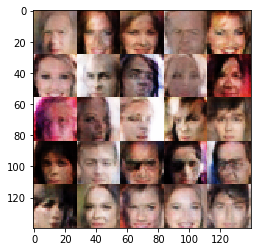

Epoch 1/1.. Steps 6010.. Discriminator Loss: 1.1404.. Generator Loss: 0.7946
Epoch 1/1.. Steps 6020.. Discriminator Loss: 1.1259.. Generator Loss: 1.1345
Epoch 1/1.. Steps 6030.. Discriminator Loss: 0.9872.. Generator Loss: 1.1218
Epoch 1/1.. Steps 6040.. Discriminator Loss: 1.2638.. Generator Loss: 0.9040
Epoch 1/1.. Steps 6050.. Discriminator Loss: 1.1207.. Generator Loss: 0.9271
Epoch 1/1.. Steps 6060.. Discriminator Loss: 1.0622.. Generator Loss: 0.9358
Epoch 1/1.. Steps 6070.. Discriminator Loss: 1.1205.. Generator Loss: 0.8106
Epoch 1/1.. Steps 6080.. Discriminator Loss: 1.2347.. Generator Loss: 0.7301
Epoch 1/1.. Steps 6090.. Discriminator Loss: 1.2086.. Generator Loss: 0.8359
Epoch 1/1.. Steps 6100.. Discriminator Loss: 1.1357.. Generator Loss: 1.0215


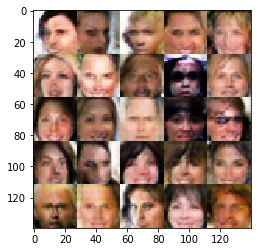

Epoch 1/1.. Steps 6110.. Discriminator Loss: 1.1490.. Generator Loss: 0.7988
Epoch 1/1.. Steps 6120.. Discriminator Loss: 1.1027.. Generator Loss: 1.4385
Epoch 1/1.. Steps 6130.. Discriminator Loss: 1.0095.. Generator Loss: 1.1628
Epoch 1/1.. Steps 6140.. Discriminator Loss: 0.9639.. Generator Loss: 1.1792
Epoch 1/1.. Steps 6150.. Discriminator Loss: 1.5607.. Generator Loss: 0.4134
Epoch 1/1.. Steps 6160.. Discriminator Loss: 1.1430.. Generator Loss: 0.8536
Epoch 1/1.. Steps 6170.. Discriminator Loss: 1.3569.. Generator Loss: 0.6200
Epoch 1/1.. Steps 6180.. Discriminator Loss: 1.0409.. Generator Loss: 0.8758
Epoch 1/1.. Steps 6190.. Discriminator Loss: 1.1021.. Generator Loss: 0.8933
Epoch 1/1.. Steps 6200.. Discriminator Loss: 1.1543.. Generator Loss: 0.8532


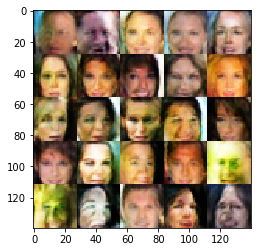

Epoch 1/1.. Steps 6210.. Discriminator Loss: 1.0873.. Generator Loss: 0.9211
Epoch 1/1.. Steps 6220.. Discriminator Loss: 1.2383.. Generator Loss: 0.6712
Epoch 1/1.. Steps 6230.. Discriminator Loss: 1.3360.. Generator Loss: 0.5399
Epoch 1/1.. Steps 6240.. Discriminator Loss: 1.0457.. Generator Loss: 1.3027
Epoch 1/1.. Steps 6250.. Discriminator Loss: 1.1483.. Generator Loss: 1.1684
Epoch 1/1.. Steps 6260.. Discriminator Loss: 1.5069.. Generator Loss: 0.4416
Epoch 1/1.. Steps 6270.. Discriminator Loss: 1.0548.. Generator Loss: 0.9594
Epoch 1/1.. Steps 6280.. Discriminator Loss: 1.2101.. Generator Loss: 1.0989
Epoch 1/1.. Steps 6290.. Discriminator Loss: 1.1200.. Generator Loss: 0.9276
Epoch 1/1.. Steps 6300.. Discriminator Loss: 1.1326.. Generator Loss: 1.0490


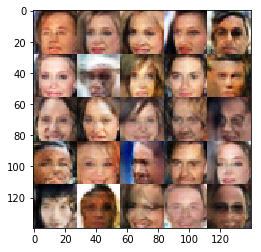

Epoch 1/1.. Steps 6310.. Discriminator Loss: 1.0812.. Generator Loss: 1.4692
Epoch 1/1.. Steps 6320.. Discriminator Loss: 1.0690.. Generator Loss: 0.9149
Epoch 1/1.. Steps 6330.. Discriminator Loss: 1.2786.. Generator Loss: 0.6995


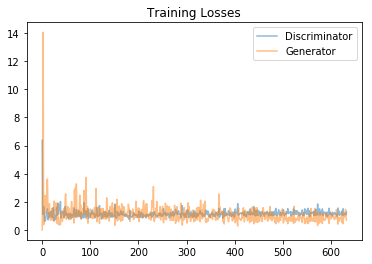

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.